### Basic Overview

We will be exploring gradient boosting methods (using xgboost) to build a predictive model for predicting housing prices, given relevant data.

In [54]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../../common_routines/')
from relevant_functions import\
    evaluate_model_score_given_predictions,\
    evaluate_model_score


#### Get clean data first

In [55]:
train_data = pd.read_csv('../../cleaned_input/train_data.csv')
validation_data = pd.read_csv('../../cleaned_input/validation_data.csv')

In [56]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       ...
       'LogGarageArea', 'LogWoodDeckSF', 'LogOpenPorchSF', 'LogEnclosedPorch',
       'Log3SsnPorch', 'LogScreenPorch', 'LogPoolArea', 'LogMiscVal',
       'LogSalePrice', 'LogMasVnrArea_times_not_missing'],
      dtype='object', length=102)

In [57]:
train_validation_data = pd.concat([train_data, validation_data])

In [58]:
test_data = pd.read_csv('../../input/test.csv')

In [59]:
test_data.isnull().sum().sum()

7000

In [60]:
## Are they indeed clean ?
train_data.isnull().sum().any()

False

In [61]:
validation_data.isnull().sum().any()

False

### Brief framework.

We will be building according the following framework .

Explore the following functionalities of the xgboost library :

1. Train model on training set and evaluate on validation set.

2. Test out early stopping feature.

3. Test out cross validation feature.

4. Verify that cross validation is indeed working as expected.

Once the above task are completed, we will be building an xgboost model using the same greedy algorithm we used for randomforests and h2o gradient boosting.


In [65]:
train_data_one_hot = pd.read_csv('../../cleaned_input/train_data_one_hot.csv')
validation_data_one_hot = pd.read_csv('../../cleaned_input/validation_data_one_hot.to_csv')
test_data_one_hot =pd.read_csv('../../cleaned_input/test_data_one_hot.csv')


In [66]:
# Let us combine the dataframes together to increase amount of data at our disposal.
train_validation_data_one_hot = pd.concat([train_data_one_hot, validation_data_one_hot])

In [82]:
all_cols_in_model = ['GrLivArea', 'OverallQual']
dep_var_col = 'LogSalePrice'

In [70]:
all_cols_in_model

['GrLivArea', 'OverallQual']

#### Train model on training set and evaluate on validation set.



In [71]:
import xgboost as xgb

In [20]:
X = train_data[all_cols_in_model].values
Y = train_data[dep_var_col].values


In [21]:
xgb_train_data = xgb.DMatrix(X, Y, feature_names=all_cols_in_model)

In [22]:
xgb_params = {'eta' : 0.1}

In [23]:
model_1 = xgb.train(params=xgb_params,
                    dtrain=xgb_train_data,
                    num_boost_round=100)

In [24]:
model_1

In [25]:
newX = validation_data[all_cols_in_model].values
newY= validation_data[dep_var_col].values

In [26]:
xgb_validation_data = xgb.DMatrix(newX, feature_names=all_cols_in_model)

In [27]:
validation_predictions = model_1.predict(xgb_validation_data)

In [28]:
evaluate_model_score_given_predictions(newY, validation_predictions)

0.20037950679249078

In [29]:
train_predictions = model_1.predict(xgb_train_data)

In [30]:
evaluate_model_score_given_predictions(Y, train_predictions)

0.14553436511977455

####  Test out early stopping feature

In [31]:
X = train_data[all_cols_in_model].values
Y = train_data[dep_var_col].values


In [32]:
xgb_train_data = xgb.DMatrix(X, Y, feature_names=all_cols_in_model)

In [33]:
xgb_validation_data = xgb.DMatrix(newX, newY, feature_names=all_cols_in_model)

In [34]:
xgb_params = {'eta' : 0.01, 'eval_metric' : 'rmse'}

In [35]:
model_1 = xgb.train(params=xgb_params,
                    dtrain=xgb_train_data,
                    num_boost_round=1000,
                    evals= [(xgb_validation_data, 'eval')],
                    early_stopping_rounds=5)

[0]	eval-rmse:11.4121
Will train until eval-rmse hasn't improved in 5 rounds.
[1]	eval-rmse:11.2982
[2]	eval-rmse:11.1854
[3]	eval-rmse:11.0738
[4]	eval-rmse:10.9632
[5]	eval-rmse:10.8538
[6]	eval-rmse:10.7454
[7]	eval-rmse:10.6382
[8]	eval-rmse:10.532
[9]	eval-rmse:10.4269
[10]	eval-rmse:10.3228
[11]	eval-rmse:10.2197
[12]	eval-rmse:10.1177
[13]	eval-rmse:10.0168
[14]	eval-rmse:9.91679
[15]	eval-rmse:9.81782
[16]	eval-rmse:9.71984
[17]	eval-rmse:9.62284
[18]	eval-rmse:9.52681
[19]	eval-rmse:9.43174
[20]	eval-rmse:9.33762
[21]	eval-rmse:9.24445
[22]	eval-rmse:9.1522
[23]	eval-rmse:9.06088
[24]	eval-rmse:8.97059
[25]	eval-rmse:8.88119
[26]	eval-rmse:8.7927
[27]	eval-rmse:8.70508
[28]	eval-rmse:8.61834
[29]	eval-rmse:8.53247
[30]	eval-rmse:8.44745
[31]	eval-rmse:8.36329
[32]	eval-rmse:8.27997
[33]	eval-rmse:8.19747
[34]	eval-rmse:8.11581
[35]	eval-rmse:8.03496
[36]	eval-rmse:7.95491
[37]	eval-rmse:7.87567
[38]	eval-rmse:7.79722
[39]	eval-rmse:7.71955
[40]	eval-rmse:7.64267
[41]	eval-rmse

[342]	eval-rmse:0.42559
[343]	eval-rmse:0.422307
[344]	eval-rmse:0.419082
[345]	eval-rmse:0.41587
[346]	eval-rmse:0.412717
[347]	eval-rmse:0.409605
[348]	eval-rmse:0.40653
[349]	eval-rmse:0.40349
[350]	eval-rmse:0.400464
[351]	eval-rmse:0.397473
[352]	eval-rmse:0.394522
[353]	eval-rmse:0.39162
[354]	eval-rmse:0.38876
[355]	eval-rmse:0.385903
[356]	eval-rmse:0.383106
[357]	eval-rmse:0.380344
[358]	eval-rmse:0.377623
[359]	eval-rmse:0.374936
[360]	eval-rmse:0.37228
[361]	eval-rmse:0.369639
[362]	eval-rmse:0.367034
[363]	eval-rmse:0.364472
[364]	eval-rmse:0.361942
[365]	eval-rmse:0.359439
[366]	eval-rmse:0.356962
[367]	eval-rmse:0.354506
[368]	eval-rmse:0.352095
[369]	eval-rmse:0.349695
[370]	eval-rmse:0.347341
[371]	eval-rmse:0.344996
[372]	eval-rmse:0.342693
[373]	eval-rmse:0.340409
[374]	eval-rmse:0.338171
[375]	eval-rmse:0.335954
[376]	eval-rmse:0.333756
[377]	eval-rmse:0.331629
[378]	eval-rmse:0.329488
[379]	eval-rmse:0.327376
[380]	eval-rmse:0.325325
[381]	eval-rmse:0.323283
[382]	e

In [36]:
validation_predictions = model_1.predict(xgb_validation_data, ntree_limit=model_1.best_ntree_limit)

In [37]:
evaluate_model_score_given_predictions(newY, validation_predictions)

0.19538389591044977

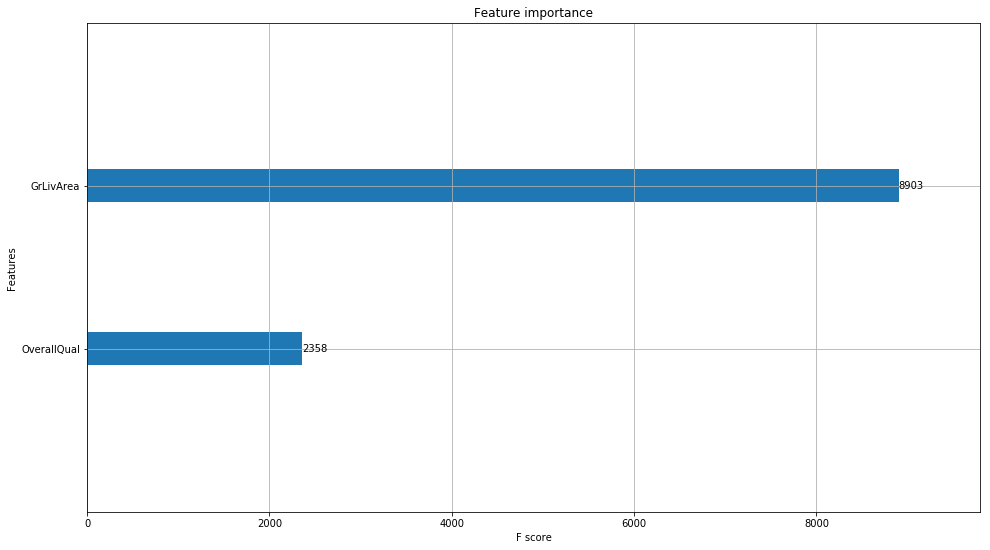

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

xgb.plot_importance(model_1,ax=ax)


#### Test out cross validation feature

In [39]:
X = train_validation_data[all_cols_in_model].values
Y = train_validation_data[dep_var_col].values


In [40]:
xgb_complete_data = xgb.DMatrix(X, Y, feature_names=all_cols_in_model)

In [41]:
xgb_params = {'eta' : 0.01, 'eval_metric' : 'rmse'}

In [42]:
model_1 = xgb.cv(params=xgb_params,
                 dtrain=xgb_complete_data,
                 num_boost_round=1000,
                 nfold=5,
                 early_stopping_rounds=5,
                 callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                            xgb.callback.early_stop(3)])

[0]	train-rmse:11.4159	test-rmse:11.4158
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
[1]	train-rmse:11.302	test-rmse:11.3019
[2]	train-rmse:11.1892	test-rmse:11.1891
[3]	train-rmse:11.0775	test-rmse:11.0775
[4]	train-rmse:10.967	test-rmse:10.967
[5]	train-rmse:10.8576	test-rmse:10.8575
[6]	train-rmse:10.7492	test-rmse:10.7492
[7]	train-rmse:10.642	test-rmse:10.6419
[8]	train-rmse:10.5358	test-rmse:10.5358
[9]	train-rmse:10.4307	test-rmse:10.4306
[10]	train-rmse:10.3266	test-rmse:10.3266
[11]	train-rmse:10.2236	test-rmse:10.2236
[12]	train-rmse:10.1216	test-rmse:10.1216
[13]	train-rmse:10.0206	test-rmse:10.0206
[14]	train-rmse:9.92068	test-rmse:9.92063
[15]	train-rmse:9.82172	test-rmse:9.82166
[16]	train-rmse:9.72375	test-rmse:9.72369
[17]	train-rmse:9.62676	test-rmse:9.6267
[18]	train-rmse:9.53074	test-rmse:9.53068
[19]	train-rmse:9.43568	test-rmse:9.43563
[20]	train-rmse:9.34157	test-rmse

[191]	train-rmse:1.69688	test-rmse:1.69782
[192]	train-rmse:1.68022	test-rmse:1.68116
[193]	train-rmse:1.66373	test-rmse:1.66468
[194]	train-rmse:1.64741	test-rmse:1.64838
[195]	train-rmse:1.63126	test-rmse:1.63224
[196]	train-rmse:1.61527	test-rmse:1.61623
[197]	train-rmse:1.59944	test-rmse:1.60041
[198]	train-rmse:1.58377	test-rmse:1.58477
[199]	train-rmse:1.56825	test-rmse:1.56924
[200]	train-rmse:1.5529	test-rmse:1.5539
[201]	train-rmse:1.5377	test-rmse:1.53866
[202]	train-rmse:1.52265	test-rmse:1.52365
[203]	train-rmse:1.50775	test-rmse:1.50876
[204]	train-rmse:1.49301	test-rmse:1.49402
[205]	train-rmse:1.47842	test-rmse:1.47941
[206]	train-rmse:1.46397	test-rmse:1.46497
[207]	train-rmse:1.44967	test-rmse:1.45066
[208]	train-rmse:1.43551	test-rmse:1.43651
[209]	train-rmse:1.4215	test-rmse:1.42249
[210]	train-rmse:1.40763	test-rmse:1.40863
[211]	train-rmse:1.3939	test-rmse:1.39491
[212]	train-rmse:1.38031	test-rmse:1.38129
[213]	train-rmse:1.36685	test-rmse:1.36782
[214]	train-rmse

[377]	train-rmse:0.319935	test-rmse:0.326564
[378]	train-rmse:0.317739	test-rmse:0.324425
[379]	train-rmse:0.315575	test-rmse:0.322339
[380]	train-rmse:0.313436	test-rmse:0.320269
[381]	train-rmse:0.311321	test-rmse:0.318241
[382]	train-rmse:0.309232	test-rmse:0.316225
[383]	train-rmse:0.307166	test-rmse:0.314247
[384]	train-rmse:0.305124	test-rmse:0.312288
[385]	train-rmse:0.303109	test-rmse:0.310352
[386]	train-rmse:0.301115	test-rmse:0.308448
[387]	train-rmse:0.299157	test-rmse:0.30658
[388]	train-rmse:0.297219	test-rmse:0.304731
[389]	train-rmse:0.295305	test-rmse:0.302908
[390]	train-rmse:0.29342	test-rmse:0.301119
[391]	train-rmse:0.291558	test-rmse:0.299354
[392]	train-rmse:0.289723	test-rmse:0.2976
[393]	train-rmse:0.287911	test-rmse:0.295877
[394]	train-rmse:0.286118	test-rmse:0.29417
[395]	train-rmse:0.284349	test-rmse:0.292495
[396]	train-rmse:0.2826	test-rmse:0.290849
[397]	train-rmse:0.280883	test-rmse:0.289209
[398]	train-rmse:0.27918	test-rmse:0.287608
[399]	train-rmse:0

[560]	train-rmse:0.17311	test-rmse:0.19612
[561]	train-rmse:0.172961	test-rmse:0.196042
[562]	train-rmse:0.172814	test-rmse:0.195958
[563]	train-rmse:0.172658	test-rmse:0.195876
[564]	train-rmse:0.172503	test-rmse:0.195789
[565]	train-rmse:0.172344	test-rmse:0.195709
[566]	train-rmse:0.172192	test-rmse:0.195623
[567]	train-rmse:0.172037	test-rmse:0.195555
[568]	train-rmse:0.171898	test-rmse:0.19548
[569]	train-rmse:0.171748	test-rmse:0.195383
[570]	train-rmse:0.1716	test-rmse:0.195308
[571]	train-rmse:0.171469	test-rmse:0.195242
[572]	train-rmse:0.171344	test-rmse:0.195179
[573]	train-rmse:0.171201	test-rmse:0.195113
[574]	train-rmse:0.171066	test-rmse:0.195053
[575]	train-rmse:0.170937	test-rmse:0.194996
[576]	train-rmse:0.170794	test-rmse:0.194912
[577]	train-rmse:0.170652	test-rmse:0.194846
[578]	train-rmse:0.170527	test-rmse:0.194782
[579]	train-rmse:0.170411	test-rmse:0.194727
[580]	train-rmse:0.170283	test-rmse:0.194667
[581]	train-rmse:0.170165	test-rmse:0.194606
[582]	train-rms

In [43]:
model_1

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,11.415892,0.008109,11.415847,0.032851
1,11.301971,0.008030,11.301927,0.032936
2,11.189189,0.007952,11.189145,0.033019
3,11.077537,0.007875,11.077491,0.033103
4,10.967000,0.007799,10.966954,0.033185
5,10.857571,0.007723,10.857524,0.033266
6,10.749235,0.007649,10.749188,0.033347
7,10.641983,0.007575,10.641936,0.033427
8,10.535805,0.007501,10.535756,0.033506
9,10.430689,0.007429,10.430640,0.033585


In [44]:
model_1[model_1['test-rmse-mean'] == model_1['test-rmse-mean'].min()]['test-rmse-mean'].values[0]

0.1923832

In [45]:
model_1[model_1['test-rmse-mean'] == model_1['test-rmse-mean'].min()].index[0]

681

In [46]:
# Getting the best model from the cross validation procedure.
model_2 = xgb.train(params=xgb_params,
                    dtrain=xgb_complete_data,
                    num_boost_round=681)

In [47]:
train_predictions = model_2.predict(xgb_complete_data)

In [48]:
evaluate_model_score_given_predictions(Y, train_predictions)

0.16530383214349179

#### Verify that cross validation is indeed working as expected

In [49]:
X = train_validation_data[all_cols_in_model].values
Y = train_validation_data[dep_var_col].values


In [50]:
xgb_complete_data = xgb.DMatrix(X, Y, feature_names=all_cols_in_model)

In [51]:
xgb_params = {'eta' : 0.01, 'eval_metric' : 'rmse'}

In [52]:
len(train_validation_data)

1460

In [53]:
model_1 = xgb.cv(params=xgb_params,
                 dtrain=xgb_complete_data,
                 num_boost_round=1000,
                 folds=[([i for i in range(730)], [i for i in range(730,1460)]),
                        ([i for i in range(730,1460)], [i for i in range(730)])],
                 early_stopping_rounds=5)

In [54]:
model_1

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,11.415952,0.006531,11.415952,0.006649
1,11.302088,0.006478,11.302089,0.006715
2,11.189364,0.006424,11.189364,0.006780
3,11.077767,0.006373,11.077767,0.006844
4,10.967284,0.006322,10.967284,0.006908
5,10.857908,0.006272,10.857909,0.006971
6,10.749624,0.006221,10.749625,0.007033
7,10.642425,0.006173,10.642424,0.007095
8,10.536296,0.006124,10.536296,0.007156
9,10.431229,0.006076,10.431228,0.007218


In [55]:
X = train_validation_data[0:730][all_cols_in_model].values
Y = train_validation_data[0:730][dep_var_col].values


newX = train_validation_data[730:1460][all_cols_in_model].values
newY = train_validation_data[730:1460][dep_var_col].values


In [56]:
xgb_train_data_1 = xgb.DMatrix(X, Y, feature_names=all_cols_in_model)
xgb_train_data_2 = xgb.DMatrix(newX, newY, feature_names=all_cols_in_model)

In [57]:
xgb_params = {'eta' : 0.01, 'eval_metric' : 'rmse'}

In [58]:
# Getting the best model from the cross validation procedure.
model_train_data_1 = xgb.train(params=xgb_params, 
                               dtrain=xgb_train_data_1,
                               num_boost_round=662)

In [59]:
train_score_1 = evaluate_model_score_given_predictions(Y, model_train_data_1.predict(xgb_train_data_1))

In [60]:
# Getting the best model from the cross validation procedure.
model_train_data_2 = xgb.train(params=xgb_params, 
                               dtrain=xgb_train_data_2,
                               num_boost_round=662)

In [61]:
train_score_2 = evaluate_model_score_given_predictions(newY, model_train_data_2.predict(xgb_train_data_2))

In [62]:
train_score_mean = (train_score_1 + train_score_2)/2.0
train_score_std = np.sqrt(((train_score_1 - train_score_mean)**2 + (train_score_2 - train_score_mean)**2)/2.0)

In [63]:
train_score_mean

0.15674891819778147

In [64]:
train_score_std

0.009303886649595985

In [65]:
test_score_1 = evaluate_model_score_given_predictions(newY, model_train_data_1.predict(xgb_train_data_2))
test_score_2 = evaluate_model_score_given_predictions(Y, model_train_data_2.predict(xgb_train_data_1))

In [66]:
test_score_mean = (test_score_1 + test_score_2)/2.0
test_score_std = np.sqrt(((test_score_1 - test_score_mean)**2 + (test_score_2 - test_score_mean)**2)/2.0)

In [67]:
test_score_mean

0.19701882484853125

In [68]:
test_score_std

0.00884801062682225

#### Building model using greedy algorithm.
At every stage, we add the predictor which reduces the cross validation score the most. However, since we are using one hot encoding, the number of predictors will be very large and hence the algorithm can take ages to complete. Hence, we employ the following modification :

Keep one hot encodings of one categorical variable as a group and them as a whole while testing for the next variable to be added. If the lot falls on this categorical variable, then each of the one hot encoded predictors are added one by one to model, in the order of predictive power (measured by the cross validation score obtained after addition) and the group obtaining the highest predictive power is retained in the model (occasinoally, we may choose not to add a one hot encoded value of a variable if we feel that the dimensionality is increasing a lot).

In [ ]:
ALL_COLUMNS = [(),
 ('MSSubClass_120',
  'MSSubClass_150',
  'MSSubClass_160',
  'MSSubClass_180',
  'MSSubClass_190',
  'MSSubClass_20',
  'MSSubClass_30',
  'MSSubClass_40',
  'MSSubClass_45',
  'MSSubClass_50',
  'MSSubClass_60',
  'MSSubClass_70',
  'MSSubClass_75',
  'MSSubClass_80',
  'MSSubClass_85',
  'MSSubClass_90'),
 ('MSZoning_C (all)',
  'MSZoning_FV',
  'MSZoning_RH',
  'MSZoning_RL',
  'MSZoning_RM'),
 (),
 ('LotArea',),
 ('Street_Grvl', 'Street_Pave'),
 ('LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg'),
 ('LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl'),
 ('Utilities_AllPub', 'Utilities_NoSeWa'),
 ('LotConfig_Corner',
  'LotConfig_CulDSac',
  'LotConfig_FR2',
  'LotConfig_FR3',
  'LotConfig_Inside'),
 ('LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev'),
 ('Neighborhood_Blmngtn',
  'Neighborhood_Blueste',
  'Neighborhood_BrDale',
  'Neighborhood_BrkSide',
  'Neighborhood_ClearCr',
  'Neighborhood_CollgCr',
  'Neighborhood_Crawfor',
  'Neighborhood_Edwards',
  'Neighborhood_Gilbert',
  'Neighborhood_IDOTRR',
  'Neighborhood_MeadowV',
  'Neighborhood_Mitchel',
  'Neighborhood_NAmes',
  'Neighborhood_NPkVill',
  'Neighborhood_NWAmes',
  'Neighborhood_NoRidge',
  'Neighborhood_NridgHt',
  'Neighborhood_OldTown',
  'Neighborhood_SWISU',
  'Neighborhood_Sawyer',
  'Neighborhood_SawyerW',
  'Neighborhood_Somerst',
  'Neighborhood_StoneBr',
  'Neighborhood_Timber',
  'Neighborhood_Veenker'),
 ('Condition1_Artery',
  'Condition1_Feedr',
  'Condition1_Norm',
  'Condition1_PosA',
  'Condition1_PosN',
  'Condition1_RRAe',
  'Condition1_RRAn',
  'Condition1_RRNe',
  'Condition1_RRNn'),
 ('Condition2_Artery',
  'Condition2_Feedr',
  'Condition2_Norm',
  'Condition2_PosA',
  'Condition2_PosN',
  'Condition2_RRAe',
  'Condition2_RRAn',
  'Condition2_RRNn'),
 ('BldgType_1Fam',
  'BldgType_2fmCon',
  'BldgType_Duplex',
  'BldgType_Twnhs',
  'BldgType_TwnhsE'),
 ('HouseStyle_1.5Fin',
  'HouseStyle_1.5Unf',
  'HouseStyle_1Story',
  'HouseStyle_2.5Fin',
  'HouseStyle_2.5Unf',
  'HouseStyle_2Story',
  'HouseStyle_SFoyer',
  'HouseStyle_SLvl'),
 ('OverallQual',),
 ('OverallCond',),
 ('YearBuilt',),
 ('YearRemodAdd',),
 ('RoofStyle_Flat',
  'RoofStyle_Gable',
  'RoofStyle_Gambrel',
  'RoofStyle_Hip',
  'RoofStyle_Mansard',
  'RoofStyle_Shed'),
 ('RoofMatl_ClyTile',
  'RoofMatl_CompShg',
  'RoofMatl_Membran',
  'RoofMatl_Metal',
  'RoofMatl_Roll',
  'RoofMatl_Tar&Grv',
  'RoofMatl_WdShake',
  'RoofMatl_WdShngl'),
 ('Exterior1st_AsbShng',
  'Exterior1st_AsphShn',
  'Exterior1st_BrkComm',
  'Exterior1st_BrkFace',
  'Exterior1st_CBlock',
  'Exterior1st_CemntBd',
  'Exterior1st_HdBoard',
  'Exterior1st_ImStucc',
  'Exterior1st_MetalSd',
  'Exterior1st_Plywood',
  'Exterior1st_Stone',
  'Exterior1st_Stucco',
  'Exterior1st_VinylSd',
  'Exterior1st_Wd Sdng',
  'Exterior1st_WdShing'),
 ('Exterior2nd_AsbShng',
  'Exterior2nd_AsphShn',
  'Exterior2nd_Brk Cmn',
  'Exterior2nd_BrkFace',
  'Exterior2nd_CBlock',
  'Exterior2nd_CmentBd',
  'Exterior2nd_HdBoard',
  'Exterior2nd_ImStucc',
  'Exterior2nd_MetalSd',
  'Exterior2nd_Other',
  'Exterior2nd_Plywood',
  'Exterior2nd_Stone',
  'Exterior2nd_Stucco',
  'Exterior2nd_VinylSd',
  'Exterior2nd_Wd Sdng',
  'Exterior2nd_Wd Shng'),
 ('MasVnrType_BrkCmn',
  'MasVnrType_BrkFace',
  'MasVnrType_Missing',
  'MasVnrType_None',
  'MasVnrType_Stone'),
 ('MasVnrArea_times_not_missing', 'MasVnrArea_not_missing'),
 ('ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA'),
 ('ExterCond_Ex',
  'ExterCond_Fa',
  'ExterCond_Gd',
  'ExterCond_Po',
  'ExterCond_TA'),
 ('Foundation_BrkTil',
  'Foundation_CBlock',
  'Foundation_PConc',
  'Foundation_Slab',
  'Foundation_Stone',
  'Foundation_Wood'),
 ('BsmtQual_Ex',
  'BsmtQual_Fa',
  'BsmtQual_Gd',
  'BsmtQual_Missing',
  'BsmtQual_TA'),
 ('BsmtCond_Fa',
  'BsmtCond_Gd',
  'BsmtCond_Missing',
  'BsmtCond_Po',
  'BsmtCond_TA'),
 ('BsmtExposure_Av',
  'BsmtExposure_Gd',
  'BsmtExposure_Missing',
  'BsmtExposure_Mn',
  'BsmtExposure_No'),
 ('BsmtFinType1_ALQ',
  'BsmtFinType1_BLQ',
  'BsmtFinType1_GLQ',
  'BsmtFinType1_LwQ',
  'BsmtFinType1_Rec',
  'BsmtFinType1_Unf'),
 ('BsmtFinSF1',),
 ('BsmtFinType2_ALQ',
  'BsmtFinType2_BLQ',
  'BsmtFinType2_GLQ',
  'BsmtFinType2_LwQ',
  'BsmtFinType2_Rec',
  'BsmtFinType2_Unf'),
 ('BsmtUnfSF',),
 ('TotalBsmtSF',),
 ('Heating_Floor',
  'Heating_GasA',
  'Heating_GasW',
  'Heating_Grav',
  'Heating_OthW',
  'Heating_Wall'),
 ('HeatingQC_Ex',
  'HeatingQC_Fa',
  'HeatingQC_Gd',
  'HeatingQC_Po',
  'HeatingQC_TA'),
 ('CentralAir_N', 'CentralAir_Y'),
 ('Electrical_FuseA',
  'Electrical_FuseF',
  'Electrical_FuseP',
  'Electrical_Missing',
  'Electrical_Mix',
  'Electrical_SBrkr'),
 ('1stFlrSF',),
 ('2ndFlrSF',),
 ('LowQualFinSF',),
 ('GrLivArea',),
 ('BsmtFullBath',),
 ('BsmtHalfBath',),
 ('FullBath',),
 ('HalfBath',),
 ('BedroomAbvGr',),
 ('KitchenAbvGr',),
 ('KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA'),
 ('TotRmsAbvGrd',),
 ('Functional_Maj1',
  'Functional_Maj2',
  'Functional_Min1',
  'Functional_Min2',
  'Functional_Mod',
  'Functional_Sev',
  'Functional_Typ'),
 ('Fireplaces',),
 ('FireplaceQu_Ex',
  'FireplaceQu_Fa',
  'FireplaceQu_Gd',
  'FireplaceQu_Missing',
  'FireplaceQu_Po',
  'FireplaceQu_TA'),
 ('GarageType_2Types',
  'GarageType_Attchd',
  'GarageType_Basment',
  'GarageType_BuiltIn',
  'GarageType_CarPort',
  'GarageType_Detchd',
  'GarageType_Missing'),
 ('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'),
 ('GarageFinish_Fin',
  'GarageFinish_Missing',
  'GarageFinish_RFn',
  'GarageFinish_Unf'),
 ('GarageCars',),
 ('GarageArea',),
 ('GarageQual_Ex',
  'GarageQual_Fa',
  'GarageQual_Gd',
  'GarageQual_Missing',
  'GarageQual_Po',
  'GarageQual_TA'),
 ('GarageCond_Ex',
  'GarageCond_Fa',
  'GarageCond_Gd',
  'GarageCond_Missing',
  'GarageCond_Po',
  'GarageCond_TA'),
 ('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'),
 ('WoodDeckSF',),
 ('OpenPorchSF',),
 ('EnclosedPorch',),
 ('3SsnPorch',),
 ('ScreenPorch',),
 ('PoolArea',),
 ('PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_Missing'),
 ('Fence_GdPrv', 'Fence_GdWo', 'Fence_Missing', 'Fence_MnPrv', 'Fence_MnWw'),
 ('MiscFeature_Gar2',
  'MiscFeature_Missing',
  'MiscFeature_Othr',
  'MiscFeature_Shed',
  'MiscFeature_TenC'),
 ('MiscVal',),
 ('MoSold_1',
  'MoSold_10',
  'MoSold_11',
  'MoSold_12',
  'MoSold_2',
  'MoSold_3',
  'MoSold_4',
  'MoSold_5',
  'MoSold_6',
  'MoSold_7',
  'MoSold_8',
  'MoSold_9'),
 ('YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010'),
 ('SaleType_COD',
  'SaleType_CWD',
  'SaleType_Con',
  'SaleType_ConLD',
  'SaleType_ConLI',
  'SaleType_ConLw',
  'SaleType_New',
  'SaleType_Oth',
  'SaleType_WD'),
 ('SaleCondition_Abnorml',
  'SaleCondition_AdjLand',
  'SaleCondition_Alloca',
  'SaleCondition_Family',
  'SaleCondition_Normal',
  'SaleCondition_Partial'),
 ()]

In [72]:
import operator
def get_cross_val_scores_new_col(base_model_cols, 
                                 columns_to_analyze=ALL_COLUMNS,
                                 eta=0.01,
                                 num_boost_round=1000,
                                 early_stopping_rounds=5,
                                 nfold=5,
                                 train_validation_data_one_hot=train_validation_data_one_hot,
                                 dep_var_col='LogSalePrice'):
    columns_to_cross_val_score = dict()
    columns_to_num_optimal_trees = dict()
    for col in columns_to_analyze:
        # If the column was already included, skip it.
        if len(col) == 0:
            continue
            
        iter_cols = list(col)
        if any([elem in iter_cols for elem in base_model_cols]):
            continue
        
        cur_model_cols = base_model_cols + iter_cols
        print(cur_model_cols)

        X = train_validation_data_one_hot[cur_model_cols].values
        Y = train_validation_data_one_hot[dep_var_col].values
        
        xgb_complete_data = xgb.DMatrix(X, Y, feature_names=cur_model_cols)        
        
        xgb_params = {'eta' : eta, 'eval_metric' : 'rmse'}        
        
        model_1 = xgb.cv(params=xgb_params,
                         dtrain=xgb_complete_data,
                         num_boost_round=num_boost_round,
                         nfold=nfold,
                         early_stopping_rounds=early_stopping_rounds)
        
        cv_score = model_1[model_1['test-rmse-mean'] == model_1['test-rmse-mean'].min()]['test-rmse-mean'].values[0]        
        columns_to_num_optimal_trees[col] = \
            model_1[model_1['test-rmse-mean'] == model_1['test-rmse-mean'].min()].index[0]
        columns_to_cross_val_score[col] = cv_score
    
    sorted_cross_val_scores = sorted(columns_to_cross_val_score.items(), key=operator.itemgetter(1))
    sorted_columns_num_optimal_trees = list()
    for elem in sorted_cross_val_scores:
        sorted_columns_num_optimal_trees.append((elem[0], columns_to_num_optimal_trees.get(elem[0])))
    return (sorted_cross_val_scores, sorted_columns_num_optimal_trees)



In [71]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col([], columns_to_analyze=ALL_COLUMNS)

['MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']
['LotArea']
['Street_Grvl', 'Street_Pave']
['LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg']
['LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl']
['Utilities_AllPub', 'Utilities_NoSeWa']
['LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside']
['LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev']
['Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Nei

In [72]:
# sorted_cross_val_scores

[(('OverallQual',), 0.2294514),
 (('Neighborhood_Blmngtn',
   'Neighborhood_Blueste',
   'Neighborhood_BrDale',
   'Neighborhood_BrkSide',
   'Neighborhood_ClearCr',
   'Neighborhood_CollgCr',
   'Neighborhood_Crawfor',
   'Neighborhood_Edwards',
   'Neighborhood_Gilbert',
   'Neighborhood_IDOTRR',
   'Neighborhood_MeadowV',
   'Neighborhood_Mitchel',
   'Neighborhood_NAmes',
   'Neighborhood_NPkVill',
   'Neighborhood_NWAmes',
   'Neighborhood_NoRidge',
   'Neighborhood_NridgHt',
   'Neighborhood_OldTown',
   'Neighborhood_SWISU',
   'Neighborhood_Sawyer',
   'Neighborhood_SawyerW',
   'Neighborhood_Somerst',
   'Neighborhood_StoneBr',
   'Neighborhood_Timber',
   'Neighborhood_Veenker'),
  0.26774),
 (('GrLivArea',), 0.27471100000000004),
 (('GarageCars',), 0.28573360000000003),
 (('GarageArea',), 0.29092219999999996),
 (('ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA'),
  0.29324059999999996),
 (('BsmtQual_Ex',
   'BsmtQual_Fa',
   'BsmtQual_Gd',
   'BsmtQual_Missing'

In [73]:
# columns_to_num_optimal_trees

[(('OverallQual',), 828),
 (('Neighborhood_Blmngtn',
   'Neighborhood_Blueste',
   'Neighborhood_BrDale',
   'Neighborhood_BrkSide',
   'Neighborhood_ClearCr',
   'Neighborhood_CollgCr',
   'Neighborhood_Crawfor',
   'Neighborhood_Edwards',
   'Neighborhood_Gilbert',
   'Neighborhood_IDOTRR',
   'Neighborhood_MeadowV',
   'Neighborhood_Mitchel',
   'Neighborhood_NAmes',
   'Neighborhood_NPkVill',
   'Neighborhood_NWAmes',
   'Neighborhood_NoRidge',
   'Neighborhood_NridgHt',
   'Neighborhood_OldTown',
   'Neighborhood_SWISU',
   'Neighborhood_Sawyer',
   'Neighborhood_SawyerW',
   'Neighborhood_Somerst',
   'Neighborhood_StoneBr',
   'Neighborhood_Timber',
   'Neighborhood_Veenker'),
  998),
 (('GrLivArea',), 634),
 (('GarageCars',), 885),
 (('GarageArea',), 717),
 (('ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA'), 900),
 (('BsmtQual_Ex',
   'BsmtQual_Fa',
   'BsmtQual_Gd',
   'BsmtQual_Missing',
   'BsmtQual_TA'),
  894),
 (('KitchenQual_Ex', 'KitchenQual_Fa', 'Kitchen

Add 'OverallQual" and search for the next variable.

In [94]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual'])

['OverallQual', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']
['OverallQual', 'LotArea']
['OverallQual', 'Street_Grvl', 'Street_Pave']
['OverallQual', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg']
['OverallQual', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl']
['OverallQual', 'Utilities_AllPub', 'Utilities_NoSeWa']
['OverallQual', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside']
['OverallQual', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev']
['OverallQual', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr

In [95]:
# sorted_cross_val_scores

[(('GrLivArea',), 0.192375),
 (('Neighborhood_Blmngtn',
   'Neighborhood_Blueste',
   'Neighborhood_BrDale',
   'Neighborhood_BrkSide',
   'Neighborhood_ClearCr',
   'Neighborhood_CollgCr',
   'Neighborhood_Crawfor',
   'Neighborhood_Edwards',
   'Neighborhood_Gilbert',
   'Neighborhood_IDOTRR',
   'Neighborhood_MeadowV',
   'Neighborhood_Mitchel',
   'Neighborhood_NAmes',
   'Neighborhood_NPkVill',
   'Neighborhood_NWAmes',
   'Neighborhood_NoRidge',
   'Neighborhood_NridgHt',
   'Neighborhood_OldTown',
   'Neighborhood_SWISU',
   'Neighborhood_Sawyer',
   'Neighborhood_SawyerW',
   'Neighborhood_Somerst',
   'Neighborhood_StoneBr',
   'Neighborhood_Timber',
   'Neighborhood_Veenker'),
  0.19942279999999998),
 (('LotArea',), 0.2051732),
 (('1stFlrSF',), 0.20684740000000001),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSu

In [96]:
# columns_to_num_optimal_trees

[(('GrLivArea',), 688),
 (('Neighborhood_Blmngtn',
   'Neighborhood_Blueste',
   'Neighborhood_BrDale',
   'Neighborhood_BrkSide',
   'Neighborhood_ClearCr',
   'Neighborhood_CollgCr',
   'Neighborhood_Crawfor',
   'Neighborhood_Edwards',
   'Neighborhood_Gilbert',
   'Neighborhood_IDOTRR',
   'Neighborhood_MeadowV',
   'Neighborhood_Mitchel',
   'Neighborhood_NAmes',
   'Neighborhood_NPkVill',
   'Neighborhood_NWAmes',
   'Neighborhood_NoRidge',
   'Neighborhood_NridgHt',
   'Neighborhood_OldTown',
   'Neighborhood_SWISU',
   'Neighborhood_Sawyer',
   'Neighborhood_SawyerW',
   'Neighborhood_Somerst',
   'Neighborhood_StoneBr',
   'Neighborhood_Timber',
   'Neighborhood_Veenker'),
  971),
 (('LotArea',), 676),
 (('1stFlrSF',), 655),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSubClass_60',
   'MSSubClass_70',
   'MSSubCl

Add 'GrLivArea' and search for the next one.

In [97]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea'])

['OverallQual', 'GrLivArea', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']
['OverallQual', 'GrLivArea', 'LotArea']
['OverallQual', 'GrLivArea', 'Street_Grvl', 'Street_Pave']
['OverallQual', 'GrLivArea', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg']
['OverallQual', 'GrLivArea', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl']
['OverallQual', 'GrLivArea', 'Utilities_AllPub', 'Utilities_NoSeWa']
['OverallQual', 'GrLivArea', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside']
['OverallQual', 'GrLivArea', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev']
['OverallQual',

In [98]:
# sorted_cross_val_scores

[(('Neighborhood_Blmngtn',
   'Neighborhood_Blueste',
   'Neighborhood_BrDale',
   'Neighborhood_BrkSide',
   'Neighborhood_ClearCr',
   'Neighborhood_CollgCr',
   'Neighborhood_Crawfor',
   'Neighborhood_Edwards',
   'Neighborhood_Gilbert',
   'Neighborhood_IDOTRR',
   'Neighborhood_MeadowV',
   'Neighborhood_Mitchel',
   'Neighborhood_NAmes',
   'Neighborhood_NPkVill',
   'Neighborhood_NWAmes',
   'Neighborhood_NoRidge',
   'Neighborhood_NridgHt',
   'Neighborhood_OldTown',
   'Neighborhood_SWISU',
   'Neighborhood_Sawyer',
   'Neighborhood_SawyerW',
   'Neighborhood_Somerst',
   'Neighborhood_StoneBr',
   'Neighborhood_Timber',
   'Neighborhood_Veenker'),
  0.1686606),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSubClass_60',
   'MSSubClass_70',
   'MSSubClass_75',
   'MSSubClass_80',
   'MSSubClass_85',
   'MSSubClass

Now, that we have a categorical variable, iterate over each of the elements and keep adding them in the order of their predictive power.

In [101]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea'],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_BrDale']
['OverallQual', 'GrLivArea', 'Neighborhood_BrkSide']
['OverallQual', 'GrLivArea', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_Crawfor']
['OverallQual', 'GrLivArea', 'Neighborhood_Edwards']
['OverallQual', 'GrLivArea', 'Neighborhood_Gilbert']
['OverallQual', 'GrLivArea', 'Neighborhood_IDOTRR']
['OverallQual', 'GrLivArea', 'Neighborhood_MeadowV']
['OverallQual', 'GrLivArea', 'Neighborhood_Mitchel']
['OverallQual', 'GrLivArea', 'Neighborhood_NAmes']
['OverallQual', 'GrLivArea', 'Neighborhood_NPkVill']
['OverallQual', 'GrLivArea', 'Neighborhood_NWAmes']
['OverallQual', 'GrLivArea', 'Neighborhood_NoRidge']
['OverallQual', 'GrLivArea', 'Neighborhood_NridgHt']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown']
['OverallQual', 'GrLivArea', 'Neighborhood_SWISU']


In [102]:
# sorted_cross_val_scores

[(('Neighborhood_OldTown',), 0.18200619999999998),
 (('Neighborhood_IDOTRR',), 0.1904084),
 (('Neighborhood_BrDale',), 0.19091139999999998),
 (('Neighborhood_CollgCr',), 0.1912496),
 (('Neighborhood_NridgHt',), 0.1915014),
 (('Neighborhood_Veenker',), 0.19174319999999997),
 (('Neighborhood_NoRidge',), 0.1917454),
 (('Neighborhood_Edwards',), 0.1917548),
 (('Neighborhood_NAmes',), 0.19189039999999996),
 (('Neighborhood_ClearCr',), 0.191971),
 (('Neighborhood_Timber',), 0.1921654),
 (('Neighborhood_Gilbert',), 0.19219920000000001),
 (('Neighborhood_NWAmes',), 0.1922672),
 (('Neighborhood_Blmngtn',), 0.1922894),
 (('Neighborhood_StoneBr',), 0.19229980000000002),
 (('Neighborhood_NPkVill',), 0.1923952),
 (('Neighborhood_Somerst',), 0.1924368),
 (('Neighborhood_SWISU',), 0.192513),
 (('Neighborhood_BrkSide',), 0.1926182),
 (('Neighborhood_Blueste',), 0.19270140000000002),
 (('Neighborhood_MeadowV',), 0.19270879999999999),
 (('Neighborhood_Sawyer',), 0.1927174),
 (('Neighborhood_Crawfor',), 

In [103]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 'Neighborhood_OldTown'],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_BrDale']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_BrkSide']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_Crawfor']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_Edwards']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_Gilbert']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_MeadowV']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_Mitchel']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_NAmes']
['O

In [104]:
# sorted_cross_val_scores

[(('Neighborhood_IDOTRR',), 0.1794556),
 (('Neighborhood_BrDale',), 0.1797142),
 (('Neighborhood_Edwards',), 0.1810298),
 (('Neighborhood_NAmes',), 0.1811896),
 (('Neighborhood_SWISU',), 0.1812534),
 (('Neighborhood_ClearCr',), 0.181368),
 (('Neighborhood_NridgHt',), 0.18139339999999998),
 (('Neighborhood_StoneBr',), 0.1816144),
 (('Neighborhood_CollgCr',), 0.1816214),
 (('Neighborhood_BrkSide',), 0.18189139999999998),
 (('Neighborhood_Timber',), 0.181916),
 (('Neighborhood_NPkVill',), 0.1819404),
 (('Neighborhood_Gilbert',), 0.18194280000000002),
 (('Neighborhood_Blmngtn',), 0.18195460000000002),
 (('Neighborhood_Blueste',), 0.18198160000000002),
 (('Neighborhood_Veenker',), 0.1820924),
 (('Neighborhood_Somerst',), 0.1821056),
 (('Neighborhood_MeadowV',), 0.18211719999999998),
 (('Neighborhood_Sawyer',), 0.18217180000000002),
 (('Neighborhood_SawyerW',), 0.1823574),
 (('Neighborhood_NWAmes',), 0.182441),
 (('Neighborhood_NoRidge',), 0.1824446),
 (('Neighborhood_Crawfor',), 0.182706),


In [105]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR'
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrkSide']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_Crawfor']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_Edwards']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_Gilbert']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV']
[

In [107]:
# sorted_cross_val_scores

[(('Neighborhood_BrDale',), 0.1772972),
 (('Neighborhood_NridgHt',), 0.17783520000000003),
 (('Neighborhood_Edwards',), 0.17805980000000002),
 (('Neighborhood_SWISU',), 0.1782128),
 (('Neighborhood_NAmes',), 0.1787388),
 (('Neighborhood_MeadowV',), 0.17874),
 (('Neighborhood_CollgCr',), 0.17900500000000003),
 (('Neighborhood_Veenker',), 0.1791986),
 (('Neighborhood_NPkVill',), 0.17922380000000002),
 (('Neighborhood_Timber',), 0.17923039999999998),
 (('Neighborhood_Somerst',), 0.17936660000000001),
 (('Neighborhood_Blmngtn',), 0.17939299999999997),
 (('Neighborhood_Blueste',), 0.17941539999999997),
 (('Neighborhood_ClearCr',), 0.1794596),
 (('Neighborhood_StoneBr',), 0.17946659999999998),
 (('Neighborhood_Gilbert',), 0.1795202),
 (('Neighborhood_Sawyer',), 0.1795342),
 (('Neighborhood_BrkSide',), 0.1795352),
 (('Neighborhood_SawyerW',), 0.17957859999999998),
 (('Neighborhood_NWAmes',), 0.1796498),
 (('Neighborhood_NoRidge',), 0.1797078),
 (('Neighborhood_Mitchel',), 0.1800672),
 (('Neig

In [108]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale'                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_BrkSide']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_Crawfor']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_Edwards']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_Gilbert']
['OverallQual', 

In [109]:
# sorted_cross_val_scores

[(('Neighborhood_SWISU',), 0.1755406),
 (('Neighborhood_Edwards',), 0.17592939999999999),
 (('Neighborhood_NridgHt',), 0.1762534),
 (('Neighborhood_BrkSide',), 0.1767806),
 (('Neighborhood_Veenker',), 0.17694179999999998),
 (('Neighborhood_NAmes',), 0.176978),
 (('Neighborhood_MeadowV',), 0.17707699999999998),
 (('Neighborhood_CollgCr',), 0.1771556),
 (('Neighborhood_ClearCr',), 0.1772218),
 (('Neighborhood_Somerst',), 0.1772984),
 (('Neighborhood_StoneBr',), 0.177359),
 (('Neighborhood_Blmngtn',), 0.1773634),
 (('Neighborhood_Timber',), 0.1774594),
 (('Neighborhood_Gilbert',), 0.17748579999999997),
 (('Neighborhood_NPkVill',), 0.1775248),
 (('Neighborhood_Blueste',), 0.17752739999999997),
 (('Neighborhood_NoRidge',), 0.1776004),
 (('Neighborhood_NWAmes',), 0.17760499999999999),
 (('Neighborhood_Sawyer',), 0.1777994),
 (('Neighborhood_SawyerW',), 0.1778554),
 (('Neighborhood_Mitchel',), 0.17795),
 (('Neighborhood_Crawfor',), 0.17853219999999997)]

In [110]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU'
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_BrkSide']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Crawfor']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighbor

In [111]:
# sorted_cross_val_scores

[(('Neighborhood_Edwards',), 0.1742834),
 (('Neighborhood_NAmes',), 0.1750828),
 (('Neighborhood_CollgCr',), 0.1751088),
 (('Neighborhood_NridgHt',), 0.1751406),
 (('Neighborhood_BrkSide',), 0.17543979999999998),
 (('Neighborhood_ClearCr',), 0.17551),
 (('Neighborhood_NoRidge',), 0.17555939999999998),
 (('Neighborhood_MeadowV',), 0.17561600000000002),
 (('Neighborhood_Blueste',), 0.175692),
 (('Neighborhood_Veenker',), 0.1756992),
 (('Neighborhood_Blmngtn',), 0.1757222),
 (('Neighborhood_NWAmes',), 0.1758172),
 (('Neighborhood_Gilbert',), 0.175851),
 (('Neighborhood_Somerst',), 0.17588720000000002),
 (('Neighborhood_NPkVill',), 0.1758882),
 (('Neighborhood_StoneBr',), 0.17590579999999997),
 (('Neighborhood_Timber',), 0.176119),
 (('Neighborhood_Mitchel',), 0.1763094),
 (('Neighborhood_Sawyer',), 0.17633559999999998),
 (('Neighborhood_SawyerW',), 0.17645800000000003),
 (('Neighborhood_Crawfor',), 0.17661880000000002)]

In [112]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards'
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_BrkSide']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborh

In [113]:
# sorted_cross_val_scores

[(('Neighborhood_NAmes',), 0.1724358),
 (('Neighborhood_NridgHt',), 0.17290580000000003),
 (('Neighborhood_CollgCr',), 0.1731764),
 (('Neighborhood_BrkSide',), 0.1732758),
 (('Neighborhood_ClearCr',), 0.17334460000000002),
 (('Neighborhood_MeadowV',), 0.17344299999999996),
 (('Neighborhood_NoRidge',), 0.1736022),
 (('Neighborhood_NWAmes',), 0.173727),
 (('Neighborhood_Timber',), 0.1737302),
 (('Neighborhood_Veenker',), 0.17388019999999998),
 (('Neighborhood_Gilbert',), 0.1739284),
 (('Neighborhood_NPkVill',), 0.1740252),
 (('Neighborhood_Somerst',), 0.17404239999999999),
 (('Neighborhood_StoneBr',), 0.1741138),
 (('Neighborhood_Blueste',), 0.17412319999999998),
 (('Neighborhood_Sawyer',), 0.1741862),
 (('Neighborhood_Blmngtn',), 0.1743052),
 (('Neighborhood_Crawfor',), 0.1746168),
 (('Neighborhood_Mitchel',), 0.174677),
 (('Neighborhood_SawyerW',), 0.17470639999999998)]

In [114]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes'                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_Ol

In [115]:
# sorted_cross_val_scores

[(('Neighborhood_BrkSide',), 0.1713168),
 (('Neighborhood_NridgHt',), 0.1717544),
 (('Neighborhood_CollgCr',), 0.1717662),
 (('Neighborhood_NWAmes',), 0.1719208),
 (('Neighborhood_ClearCr',), 0.1719518),
 (('Neighborhood_MeadowV',), 0.1719836),
 (('Neighborhood_Gilbert',), 0.1722172),
 (('Neighborhood_Veenker',), 0.1723592),
 (('Neighborhood_StoneBr',), 0.17238640000000002),
 (('Neighborhood_Somerst',), 0.1724598),
 (('Neighborhood_NoRidge',), 0.172514),
 (('Neighborhood_Timber',), 0.17251860000000002),
 (('Neighborhood_NPkVill',), 0.1725408),
 (('Neighborhood_Blueste',), 0.1725588),
 (('Neighborhood_Blmngtn',), 0.1726298),
 (('Neighborhood_Sawyer',), 0.1727274),
 (('Neighborhood_Mitchel',), 0.172831),
 (('Neighborhood_SawyerW',), 0.1730844),
 (('Neighborhood_Crawfor',), 0.17338960000000003)]

In [116]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide'                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwar

In [117]:
# sorted_cross_val_scores

[(('Neighborhood_NridgHt',), 0.170405),
 (('Neighborhood_MeadowV',), 0.17064340000000003),
 (('Neighborhood_CollgCr',), 0.17088399999999998),
 (('Neighborhood_Gilbert',), 0.1709412),
 (('Neighborhood_Veenker',), 0.1710102),
 (('Neighborhood_ClearCr',), 0.1711336),
 (('Neighborhood_NWAmes',), 0.17124999999999999),
 (('Neighborhood_NoRidge',), 0.1713612),
 (('Neighborhood_StoneBr',), 0.171465),
 (('Neighborhood_Blueste',), 0.1714942),
 (('Neighborhood_NPkVill',), 0.1714986),
 (('Neighborhood_Blmngtn',), 0.1715744),
 (('Neighborhood_Somerst',), 0.17173480000000002),
 (('Neighborhood_Timber',), 0.17182),
 (('Neighborhood_Mitchel',), 0.17182020000000003),
 (('Neighborhood_SawyerW',), 0.1719434),
 (('Neighborhood_Sawyer',), 0.1719462),
 (('Neighborhood_Crawfor',), 0.1723278)]

In [118]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt'                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr']
['OverallQual', 'GrLivArea', 'Neighborhood_O

In [119]:
# sorted_cross_val_scores

[(('Neighborhood_CollgCr',), 0.16962059999999995),
 (('Neighborhood_MeadowV',), 0.1696594),
 (('Neighborhood_NoRidge',), 0.1696686),
 (('Neighborhood_ClearCr',), 0.16974260000000002),
 (('Neighborhood_Veenker',), 0.1699054),
 (('Neighborhood_StoneBr',), 0.1700214),
 (('Neighborhood_Mitchel',), 0.170128),
 (('Neighborhood_NWAmes',), 0.17018879999999997),
 (('Neighborhood_Gilbert',), 0.17019259999999997),
 (('Neighborhood_NPkVill',), 0.17023519999999998),
 (('Neighborhood_Blueste',), 0.170259),
 (('Neighborhood_Somerst',), 0.170332),
 (('Neighborhood_Sawyer',), 0.170405),
 (('Neighborhood_Blmngtn',), 0.1704068),
 (('Neighborhood_SawyerW',), 0.17053539999999998),
 (('Neighborhood_Timber',), 0.17073739999999998),
 (('Neighborhood_Crawfor',), 0.17127720000000002)]

In [120]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr'                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgH

In [121]:
# sorted_cross_val_scores

[(('Neighborhood_NoRidge',), 0.16884159999999998),
 (('Neighborhood_Veenker',), 0.1693376),
 (('Neighborhood_MeadowV',), 0.16942619999999997),
 (('Neighborhood_ClearCr',), 0.16944719999999996),
 (('Neighborhood_Gilbert',), 0.16945919999999998),
 (('Neighborhood_StoneBr',), 0.1695376),
 (('Neighborhood_Somerst',), 0.16957300000000003),
 (('Neighborhood_NPkVill',), 0.169609),
 (('Neighborhood_NWAmes',), 0.1696176),
 (('Neighborhood_Blueste',), 0.16965819999999998),
 (('Neighborhood_Blmngtn',), 0.16967680000000002),
 (('Neighborhood_Mitchel',), 0.16984919999999998),
 (('Neighborhood_Timber',), 0.1699022),
 (('Neighborhood_Sawyer',), 0.16991839999999997),
 (('Neighborhood_SawyerW',), 0.17023520000000003),
 (('Neighborhood_Crawfor',), 0.17053619999999997)]

In [122]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge'
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwa

In [123]:
# sorted_cross_val_scores

[(('Neighborhood_MeadowV',), 0.1683974),
 (('Neighborhood_Veenker',), 0.1684002),
 (('Neighborhood_Gilbert',), 0.16876539999999998),
 (('Neighborhood_Blmngtn',), 0.168783),
 (('Neighborhood_Timber',), 0.1688178),
 (('Neighborhood_ClearCr',), 0.1688294),
 (('Neighborhood_Somerst',), 0.168894),
 (('Neighborhood_StoneBr',), 0.169048),
 (('Neighborhood_Sawyer',), 0.1690816),
 (('Neighborhood_Blueste',), 0.1691448),
 (('Neighborhood_NPkVill',), 0.16917480000000001),
 (('Neighborhood_Mitchel',), 0.1693634),
 (('Neighborhood_NWAmes',), 0.169406),
 (('Neighborhood_SawyerW',), 0.1695634),
 (('Neighborhood_Crawfor',), 0.1700274)]

In [124]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV'                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_

In [125]:
# sorted_cross_val_scores

[(('Neighborhood_ClearCr',), 0.16796660000000002),
 (('Neighborhood_Veenker',), 0.16821640000000002),
 (('Neighborhood_NPkVill',), 0.1684178),
 (('Neighborhood_Blmngtn',), 0.1684568),
 (('Neighborhood_Gilbert',), 0.1684604),
 (('Neighborhood_StoneBr',), 0.1685726),
 (('Neighborhood_Somerst',), 0.16867100000000002),
 (('Neighborhood_Sawyer',), 0.16867519999999997),
 (('Neighborhood_Mitchel',), 0.16871300000000003),
 (('Neighborhood_Blueste',), 0.1687696),
 (('Neighborhood_Timber',), 0.168823),
 (('Neighborhood_SawyerW',), 0.16903459999999998),
 (('Neighborhood_NWAmes',), 0.1690662),
 (('Neighborhood_Crawfor',), 0.17026599999999997)]

In [126]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Crawf

In [127]:
# sorted_cross_val_scores

[(('Neighborhood_Veenker',), 0.1675694),
 (('Neighborhood_StoneBr',), 0.1676326),
 (('Neighborhood_NPkVill',), 0.16793600000000003),
 (('Neighborhood_Blmngtn',), 0.16801059999999998),
 (('Neighborhood_Somerst',), 0.16801300000000002),
 (('Neighborhood_Sawyer',), 0.1680318),
 (('Neighborhood_Blueste',), 0.1680634),
 (('Neighborhood_Gilbert',), 0.168072),
 (('Neighborhood_Timber',), 0.16807539999999999),
 (('Neighborhood_NWAmes',), 0.1680758),
 (('Neighborhood_Mitchel',), 0.16820980000000002),
 (('Neighborhood_SawyerW',), 0.16831580000000002),
 (('Neighborhood_Crawfor',), 0.169598)]

In [128]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_Meado

In [129]:
# sorted_cross_val_scores

[(('Neighborhood_Gilbert',), 0.1675222),
 (('Neighborhood_Blmngtn',), 0.16754180000000002),
 (('Neighborhood_Blueste',), 0.16757780000000003),
 (('Neighborhood_StoneBr',), 0.167609),
 (('Neighborhood_Somerst',), 0.1676314),
 (('Neighborhood_Mitchel',), 0.167787),
 (('Neighborhood_NPkVill',), 0.16778839999999998),
 (('Neighborhood_NWAmes',), 0.16790180000000002),
 (('Neighborhood_Sawyer',), 0.16798699999999997),
 (('Neighborhood_SawyerW',), 0.16808479999999998),
 (('Neighborhood_Timber',), 0.168214),
 (('Neighborhood_Crawfor',), 0.168828)]

In [130]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert'
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_Collg

In [131]:
# sorted_cross_val_scores

[(('Neighborhood_NPkVill',), 0.1674984),
 (('Neighborhood_Somerst',), 0.16755080000000003),
 (('Neighborhood_Blmngtn',), 0.1675756),
 (('Neighborhood_StoneBr',), 0.1676258),
 (('Neighborhood_Mitchel',), 0.167655),
 (('Neighborhood_Blueste',), 0.16767140000000003),
 (('Neighborhood_NWAmes',), 0.1677016),
 (('Neighborhood_Sawyer',), 0.16777859999999997),
 (('Neighborhood_SawyerW',), 0.16788699999999998),
 (('Neighborhood_Timber',), 0.168124),
 (('Neighborhood_Crawfor',), 0.168852)]

In [132]:
# # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill'                                  
#                                  ],
#                                  columns_to_analyze = 
#                                  [('Neighborhood_Blmngtn',),
#                                   ('Neighborhood_Blueste',),
#                                   ('Neighborhood_BrDale',),
#                                   ('Neighborhood_BrkSide',),
#                                   ('Neighborhood_ClearCr',),
#                                   ('Neighborhood_CollgCr',),
#                                   ('Neighborhood_Crawfor',),
#                                   ('Neighborhood_Edwards',),
#                                   ('Neighborhood_Gilbert',),
#                                   ('Neighborhood_IDOTRR',),
#                                   ('Neighborhood_MeadowV',),
#                                   ('Neighborhood_Mitchel',),
#                                   ('Neighborhood_NAmes',),
#                                   ('Neighborhood_NPkVill',),
#                                   ('Neighborhood_NWAmes',),
#                                   ('Neighborhood_NoRidge',),
#                                   ('Neighborhood_NridgHt',),
#                                   ('Neighborhood_OldTown',),
#                                   ('Neighborhood_SWISU',),
#                                   ('Neighborhood_Sawyer',),
#                                   ('Neighborhood_SawyerW',),
#                                   ('Neighborhood_Somerst',),
#                                   ('Neighborhood_StoneBr',),
#                                   ('Neighborhood_Timber',),
#                                   ( 'Neighborhood_Veenker',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'Neighborhood_Blueste']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSi

In [133]:
# sorted_cross_val_scores

[(('Neighborhood_Sawyer',), 0.167507),
 (('Neighborhood_Blueste',), 0.16768960000000002),
 (('Neighborhood_Blmngtn',), 0.167694),
 (('Neighborhood_Somerst',), 0.1677128),
 (('Neighborhood_StoneBr',), 0.1677276),
 (('Neighborhood_NWAmes',), 0.1678074),
 (('Neighborhood_Mitchel',), 0.16781059999999998),
 (('Neighborhood_SawyerW',), 0.16781359999999998),
 (('Neighborhood_Timber',), 0.16827399999999998),
 (('Neighborhood_Crawfor',), 0.1687554)]

#### Something noticeable.

We see that we are able to get a better cross validation score using a smaller number of one hot encoded predictors. This looks good and can be similarly used in the case of other categorical variables as well.

In [134]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill'                                  
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neig

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'CentralAir_N', 'CentralAir_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Missing', 'Electrical_Mix', 'Electrical_SBrkr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neigh

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'GarageCars']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'GarageArea']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_N

In [137]:
# sorted_cross_val_scores

[(('BsmtFinSF1',), 0.156174),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSubClass_60',
   'MSSubClass_70',
   'MSSubClass_75',
   'MSSubClass_80',
   'MSSubClass_85',
   'MSSubClass_90'),
  0.1584074),
 (('BsmtFinType1_ALQ',
   'BsmtFinType1_BLQ',
   'BsmtFinType1_GLQ',
   'BsmtFinType1_LwQ',
   'BsmtFinType1_Rec',
   'BsmtFinType1_Unf'),
  0.160692),
 (('TotalBsmtSF',), 0.1609258),
 (('BsmtFullBath',), 0.16206340000000002),
 (('2ndFlrSF',), 0.1621808),
 (('BsmtQual_Ex',
   'BsmtQual_Fa',
   'BsmtQual_Gd',
   'BsmtQual_Missing',
   'BsmtQual_TA'),
  0.16222519999999999),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'HouseStyle_1Story',
   'HouseStyle_2.5Fin',
   'HouseStyle_2.5Unf',
   'HouseStyle_2Story',
   'HouseStyle_SFoyer',
   'HouseStyle_SLvl'),
  0.16256520000000002),
 (('GarageFinish_Fin',
   'GarageFinish

Add 'BsmtFinSF1' and look for the next one.

In [138]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_V

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exte

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'CentralAir_N', 'CentralAir_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDa

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'GarageFinish_Fin', 'GarageFinish_Missing', 'GarageFinish_RFn', 'GarageFinish_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'GarageCars']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighbor

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']


In [139]:
# sorted_cross_val_scores

[(('OverallCond',), 0.1502288),
 (('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'),
  0.15072239999999998),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSubClass_60',
   'MSSubClass_70',
   'MSSubClass_75',
   'MSSubClass_80',
   'MSSubClass_85',
   'MSSubClass_90'),
  0.1508756),
 (('YearRemodAdd',), 0.15095580000000003),
 (('SaleCondition_Abnorml',
   'SaleCondition_AdjLand',
   'SaleCondition_Alloca',
   'SaleCondition_Family',
   'SaleCondition_Normal',
   'SaleCondition_Partial'),
  0.1520796),
 (('GarageCars',), 0.1522666),
 (('GarageArea',), 0.1528866),
 (('KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA'),
  0.1529118),
 (('ExterCond_Ex',
   'ExterCond_Fa',
   'ExterCond_Gd',
   'ExterCond_Po',
   'ExterCond_TA'),
  0.1532208),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'Hou

Add 'OverallCond' and look for the next.

In [140]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighbo

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'CentralAir_N', 'CentralAir_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Missing', 'Electrical_Mix', 'Electrical_SBrkr']
['OverallQual', 'GrLivAr

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'GarageFinish_Fin', 'GarageFinish_Missing', 'GarageFinish_RFn', 'GarageFinish_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'GarageCars']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'N

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'SaleCondition_Abnorml', 'S

In [141]:
# sorted_cross_val_scores

[(('YearBuilt',), 0.14210260000000002),
 (('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'),
  0.14284999999999998),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSubClass_60',
   'MSSubClass_70',
   'MSSubClass_75',
   'MSSubClass_80',
   'MSSubClass_85',
   'MSSubClass_90'),
  0.14423360000000002),
 (('GarageCars',), 0.1449742),
 (('YearRemodAdd',), 0.145706),
 (('TotalBsmtSF',), 0.1461222),
 (('GarageArea',), 0.146529),
 (('1stFlrSF',), 0.1465582),
 (('SaleCondition_Abnorml',
   'SaleCondition_AdjLand',
   'SaleCondition_Alloca',
   'SaleCondition_Family',
   'SaleCondition_Normal',
   'SaleCondition_Partial'),
  0.1467254),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.14676540000000002),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'HouseStyle_1Sto

Add 'YearBuilt' and look for the next.

In [142]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborho

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_Collg

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'CentralAir_N', 'CentralAir_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Missing', 'Electrical_Mix', 'Electrical_SBrkr'

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'GarageFinish_Fin', 'GarageFinish_Missing', 'GarageFinish_RFn', 'GarageFinish_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'GarageCars']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown',

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', '

In [143]:
# sorted_cross_val_scores

[(('Fireplaces',), 0.1370452),
 (('GarageCars',), 0.1376796),
 (('FireplaceQu_Ex',
   'FireplaceQu_Fa',
   'FireplaceQu_Gd',
   'FireplaceQu_Missing',
   'FireplaceQu_Po',
   'FireplaceQu_TA'),
  0.1380206),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSubClass_60',
   'MSSubClass_70',
   'MSSubClass_75',
   'MSSubClass_80',
   'MSSubClass_85',
   'MSSubClass_90'),
  0.13818139999999998),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'HouseStyle_1Story',
   'HouseStyle_2.5Fin',
   'HouseStyle_2.5Unf',
   'HouseStyle_2Story',
   'HouseStyle_SFoyer',
   'HouseStyle_SLvl'),
  0.13846399999999998),
 (('TotalBsmtSF',), 0.1386908),
 (('LotArea',), 0.1389886),
 (('1stFlrSF',), 0.13962120000000003),
 (('GarageArea',), 0.1397092),
 (('2ndFlrSF',), 0.1398344),
 (('MSZoning_C (all)',
   'MSZoning_FV',
   'MSZoning_RH',
   'MSZon

Add 'Fireplaces' and look for the next.

In [145]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neig

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', 'CentralAir_N', 'CentralAir_Y']
['OverallQ

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', 'GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', 'GarageFinish_Fin', 'GarageFinish_Missing', 'GarageFinish_RFn'

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'Y

In [146]:
# sorted_cross_val_scores

[(('2ndFlrSF',), 0.13366119999999998),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'HouseStyle_1Story',
   'HouseStyle_2.5Fin',
   'HouseStyle_2.5Unf',
   'HouseStyle_2Story',
   'HouseStyle_SFoyer',
   'HouseStyle_SLvl'),
  0.13396579999999997),
 (('GarageArea',), 0.13427099999999997),
 (('1stFlrSF',), 0.1344044),
 (('LotArea',), 0.13447760000000003),
 (('GarageCars',), 0.1347358),
 (('TotalBsmtSF',), 0.1348776),
 (('MSSubClass_120',
   'MSSubClass_150',
   'MSSubClass_160',
   'MSSubClass_180',
   'MSSubClass_190',
   'MSSubClass_20',
   'MSSubClass_30',
   'MSSubClass_40',
   'MSSubClass_45',
   'MSSubClass_50',
   'MSSubClass_60',
   'MSSubClass_70',
   'MSSubClass_75',
   'MSSubClass_80',
   'MSSubClass_85',
   'MSSubClass_90'),
  0.13494540000000002),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.1355988),
 (('LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl'),
  0.1356498),
 (('MSZoning_C (all)',
   'MSZoning_FV',
   'MSZoning_RH',
   'MSZo

Add '2ndFlrSF' and look for the next.

In [147]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighbor

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', '

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'GarageFinish_Fin', 'GarageFinish_Miss

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'Over

In [148]:
# sorted_cross_val_scores

[(('MSZoning_C (all)',
   'MSZoning_FV',
   'MSZoning_RH',
   'MSZoning_RL',
   'MSZoning_RM'),
  0.1319802),
 (('GarageCars',), 0.1325034),
 (('GarageArea',), 0.132597),
 (('LotArea',), 0.13271580000000002),
 (('HeatingQC_Ex',
   'HeatingQC_Fa',
   'HeatingQC_Gd',
   'HeatingQC_Po',
   'HeatingQC_TA'),
  0.1330964),
 (('LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl'),
  0.1331178),
 (('Condition1_Artery',
   'Condition1_Feedr',
   'Condition1_Norm',
   'Condition1_PosA',
   'Condition1_PosN',
   'Condition1_RRAe',
   'Condition1_RRAn',
   'Condition1_RRNe',
   'Condition1_RRNn'),
  0.133235),
 (('CentralAir_N', 'CentralAir_Y'), 0.1333818),
 (('BsmtQual_Ex',
   'BsmtQual_Fa',
   'BsmtQual_Gd',
   'BsmtQual_Missing',
   'BsmtQual_TA'),
  0.13341699999999998),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.1334208),
 (('SaleCondition_Abnorml',
   'SaleCondition_AdjLand',
   'SaleCondition_Alloca',
   'SaleCondition_Family',
   'SaleCondition_Normal',
   

Add each of the MS_Zoning variables one by one 

In [150]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF'
#                                  ],
#                                  columns_to_analyze=[('MSZoning_C (all)',),
#                                                       ('MSZoning_FV',),
#                                                       ('MSZoning_RH',),
#                                                       ('MSZoning_RL',),
#                                                       ('MSZoning_RM',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_FV']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborh

In [151]:
# sorted_cross_val_scores

[(('MSZoning_C (all)',), 0.1330992),
 (('MSZoning_RH',), 0.1336704),
 (('MSZoning_RL',), 0.13369199999999998),
 (('MSZoning_FV',), 0.13421339999999998),
 (('MSZoning_RM',), 0.13451780000000002)]

In [152]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('MSZoning_FV',),
#                                                       ('MSZoning_RH',),
#                                                       ('MSZoning_RL',),
#                                                       ('MSZoning_RM',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_FV']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH']
['OverallQual', 'GrLivArea',

In [153]:
# sorted_cross_val_scores

[(('MSZoning_RH',), 0.1323822),
 (('MSZoning_RL',), 0.132616),
 (('MSZoning_FV',), 0.1327114),
 (('MSZoning_RM',), 0.1332806)]

In [154]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH'                                  
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('MSZoning_FV',),
#                                                       ('MSZoning_RH',),
#                                                       ('MSZoning_RL',),
#                                                       ('MSZoning_RM',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_FV']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL'

In [155]:
# sorted_cross_val_scores

[(('MSZoning_RM',), 0.13231500000000002),
 (('MSZoning_RL',), 0.13264179999999998),
 (('MSZoning_FV',), 0.1326736)]

In [156]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH',
#                                   'MSZoning_RM'                                   
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('MSZoning_FV',),
#                                                       ('MSZoning_RH',),
#                                                       ('MSZoning_RL',),
#                                                       ('MSZoning_RM',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_FV']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH'

In [157]:
# sorted_cross_val_scores

[(('MSZoning_RL',), 0.1320066), (('MSZoning_FV',), 0.1325686)]

In [158]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH',
#                                   'MSZoning_RM',
#                                   'MSZoning_RL'                                   
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('MSZoning_FV',),
#                                                       ('MSZoning_RH',),
#                                                       ('MSZoning_RL',),
#                                                       ('MSZoning_RM',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'MSZoning_FV']


In [159]:
# sorted_cross_val_scores

[(('MSZoning_FV',), 0.1319964)]

#### Questionable.

It is easy to see that the MS_Zoning variables are interdependent and it does not make any sense to add all of them. 
Hence, we do not add the last variable MSZoning_FV.

We search for the next variable.

In [163]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH',
#                                   'MSZoning_RM',
#                                   'MSZoning_RL'                                   
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_Nr

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veen

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'BsmtUnfSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'TotRmsAbvGrd']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'ScreenPorch']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)'

In [164]:
# sorted_cross_val_scores

[(('LotArea',), 0.1293802),
 (('GarageCars',), 0.129557),
 (('GarageArea',), 0.1309174),
 (('Condition1_Artery',
   'Condition1_Feedr',
   'Condition1_Norm',
   'Condition1_PosA',
   'Condition1_PosN',
   'Condition1_RRAe',
   'Condition1_RRAn',
   'Condition1_RRNe',
   'Condition1_RRNn'),
  0.13111160000000002),
 (('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'),
  0.13122779999999998),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.131297),
 (('CentralAir_N', 'CentralAir_Y'), 0.13144379999999997),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.1315356),
 (('HeatingQC_Ex',
   'HeatingQC_Fa',
   'HeatingQC_Gd',
   'HeatingQC_Po',
   'HeatingQC_TA'),
  0.13166719999999998),
 (('LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl'),
  0.13168300000000002),
 (('KitchenAbvGr',), 0.1317194),
 (('BsmtQual_Ex',
   'BsmtQual_Fa',
   'BsmtQual_Gd',
   'BsmtQual_Missing',
   'BsmtQual_TA'),
  0.1317802)

We add 'LotArea' and look for the next.

In [165]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH',
#                                   'MSZoning_RM',
#                                   'MSZoning_RL',
#                                   'LotArea'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neig

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighb

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtUnfSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'TotRmsAbvGrd']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZon

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', '3SsnPorch']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning

In [166]:
# sorted_cross_val_scores

[(('BsmtCond_Fa',
   'BsmtCond_Gd',
   'BsmtCond_Missing',
   'BsmtCond_Po',
   'BsmtCond_TA'),
  0.1281686),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.1282644),
 (('CentralAir_N', 'CentralAir_Y'), 0.1285064),
 (('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'), 0.1285156),
 (('Condition2_Artery',
   'Condition2_Feedr',
   'Condition2_Norm',
   'Condition2_PosA',
   'Condition2_PosN',
   'Condition2_RRAe',
   'Condition2_RRAn',
   'Condition2_RRNn'),
  0.1285158),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.128525),
 (('GarageQual_Ex',
   'GarageQual_Fa',
   'GarageQual_Gd',
   'GarageQual_Missing',
   'GarageQual_Po',
   'GarageQual_TA'),
  0.1285398),
 (('BsmtExposure_Av',
   'BsmtExposure_Gd',
   'BsmtExposure_Missing',
   'BsmtExposure_Mn',
   'BsmtExposure_No'),
  0.1286274),
 (('GarageCars',), 0.12868960000000002),
 (('SaleType_COD',
   'SaleType_CWD',
   'SaleType_Con',
   'SaleType_ConLD',
   'SaleT

Add BmstCond as a group.

In [168]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM',
#                                   'MSZoning_RL',
#                                   'LotArea'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('BsmtCond_Fa',),
#                                                       ('BsmtCond_Gd',),
#                                                       ('BsmtCond_Missing',),
#                                                       ('BsmtCond_Po',),                                     
#                                                       ('BsmtCond_TA',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_Fa']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoni

In [169]:
# sorted_cross_val_scores

[(('BsmtCond_TA',), 0.1283492),
 (('BsmtCond_Missing',), 0.128762),
 (('BsmtCond_Po',), 0.1295642),
 (('BsmtCond_Gd',), 0.12962579999999999),
 (('BsmtCond_Fa',), 0.1296594)]

In [170]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM',
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('BsmtCond_Fa',),
#                                                       ('BsmtCond_Gd',),
#                                                       ('BsmtCond_Missing',),
#                                                       ('BsmtCond_Po',),                                     
#                                                       ('BsmtCond_TA',)])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'BsmtCond_Fa']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2nd

In [171]:
# sorted_cross_val_scores

[(('BsmtCond_Gd',), 0.1284548),
 (('BsmtCond_Missing',), 0.12854179999999998),
 (('BsmtCond_Fa',), 0.1286482),
 (('BsmtCond_Po',), 0.1289224)]

We add 'BsmtCond_Gd' and look the next variable.

In [172]:
#   # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM',
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_Cl

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'BsmtUnfSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFl

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'TotRmsAbvGrd']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2n

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', '3SsnPorch']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFl

In [173]:
# sorted_cross_val_scores

[(('GarageArea',), 0.1274708),
 (('GarageCars',), 0.12750820000000002),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.12787539999999997),
 (('GarageQual_Ex',
   'GarageQual_Fa',
   'GarageQual_Gd',
   'GarageQual_Missing',
   'GarageQual_Po',
   'GarageQual_TA'),
  0.1280014),
 (('SaleType_COD',
   'SaleType_CWD',
   'SaleType_Con',
   'SaleType_ConLD',
   'SaleType_ConLI',
   'SaleType_ConLw',
   'SaleType_New',
   'SaleType_Oth',
   'SaleType_WD'),
  0.12805419999999998),
 (('Condition2_Artery',
   'Condition2_Feedr',
   'Condition2_Norm',
   'Condition2_PosA',
   'Condition2_PosN',
   'Condition2_RRAe',
   'Condition2_RRAn',
   'Condition2_RRNn'),
  0.1280674),
 (('Condition1_Artery',
   'Condition1_Feedr',
   'Condition1_Norm',
   'Condition1_PosA',
   'Condition1_PosN',
   'Condition1_RRAe',
   'Condition1_RRAn',
   'Condition1_RRNe',
   'Condition1_RRNn'),
  0.1280686),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'Hous

In [174]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM',
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea'
#                                  ])

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'N

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'BsmtUnfSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Firep

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', '3SsnPorch']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Firep

In [175]:
# sorted_cross_val_scores

[(('HeatingQC_Ex',
   'HeatingQC_Fa',
   'HeatingQC_Gd',
   'HeatingQC_Po',
   'HeatingQC_TA'),
  0.1265986),
 (('CentralAir_N', 'CentralAir_Y'), 0.1267024),
 (('1stFlrSF',), 0.12692720000000002),
 (('GarageCars',), 0.1269422),
 (('Condition2_Artery',
   'Condition2_Feedr',
   'Condition2_Norm',
   'Condition2_PosA',
   'Condition2_PosN',
   'Condition2_RRAe',
   'Condition2_RRAn',
   'Condition2_RRNn'),
  0.1269556),
 (('BsmtFinType2_ALQ',
   'BsmtFinType2_BLQ',
   'BsmtFinType2_GLQ',
   'BsmtFinType2_LwQ',
   'BsmtFinType2_Rec',
   'BsmtFinType2_Unf'),
  0.127054),
 (('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'), 0.127061),
 (('TotalBsmtSF',), 0.12717240000000002),
 (('FullBath',), 0.127185),
 (('BedroomAbvGr',), 0.1271992),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.1272152),
 (('BsmtExposure_Av',
   'BsmtExposure_Gd',
   'BsmtExposure_Missing',
   'BsmtExposure_Mn',
   'BsmtExposure_No'),
  0.12721999999999997),
 (('YearRemodAdd',), 0.1272416),
 (('ScreenP

We add 'HeatingQC' variables as a group.

In [176]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('HeatingQC_Ex',),
#                                                       ('HeatingQC_Fa',),
#                                                       ('HeatingQC_Gd',),
#                                                       ('HeatingQC_Po',),                                     
#                                                       ('HeatingQC_TA',)])                                 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fi

In [177]:
# sorted_cross_val_scores

[(('HeatingQC_Ex',), 0.1273156),
 (('HeatingQC_Gd',), 0.127397),
 (('HeatingQC_Fa',), 0.1278296),
 (('HeatingQC_Po',), 0.12806520000000002),
 (('HeatingQC_TA',), 0.1281638)]

In [178]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('HeatingQC_Ex',),
#                                                       ('HeatingQC_Fa',),
#                                                       ('HeatingQC_Gd',),
#                                                       ('HeatingQC_Po',),                                     
#                                                       ('HeatingQC_TA',)])                                 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Fa']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 

In [179]:
# sorted_cross_val_scores

[(('HeatingQC_Gd',), 0.12646459999999998),
 (('HeatingQC_Fa',), 0.12655339999999998),
 (('HeatingQC_Po',), 0.1268678),
 (('HeatingQC_TA',), 0.1269392)]

In [180]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('HeatingQC_Ex',),
#                                                       ('HeatingQC_Fa',),
#                                                       ('HeatingQC_Gd',),
#                                                       ('HeatingQC_Po',),                                     
#                                                       ('HeatingQC_TA',)])                                 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'HeatingQC_Fa']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1',

In [181]:
# sorted_cross_val_scores

[(('HeatingQC_Fa',), 0.12638459999999999),
 (('HeatingQC_TA',), 0.12677199999999997),
 (('HeatingQC_Po',), 0.1270926)]

In [182]:
#  # Let us begin our testing on a good number of trees witha a low learning rate and see how it looks.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'HeatingQC_Fa'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('HeatingQC_Ex',),
#                                                       ('HeatingQC_Fa',),
#                                                       ('HeatingQC_Gd',),
#                                                       ('HeatingQC_Po',),                                     
#                                                       ('HeatingQC_TA',)])                                 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'HeatingQC_Fa', 'HeatingQC_Po']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill

In [183]:
# sorted_cross_val_scores

[(('HeatingQC_Po',), 0.12636719999999999), (('HeatingQC_TA',), 0.1271314)]

The improvement is extremely minimal and we do not believe it is worth the increase in dimensionality. Hence we move onto other variables.

In [184]:
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd'
#                                  ])                                 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborho

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neig

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neig

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'EnclosedPorch']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1'

In [185]:
# sorted_cross_val_scores

[(('YearRemodAdd',), 0.1258112),
 (('Heating_Floor',
   'Heating_GasA',
   'Heating_GasW',
   'Heating_Grav',
   'Heating_OthW',
   'Heating_Wall'),
  0.1258908),
 (('Condition1_Artery',
   'Condition1_Feedr',
   'Condition1_Norm',
   'Condition1_PosA',
   'Condition1_PosN',
   'Condition1_RRAe',
   'Condition1_RRAn',
   'Condition1_RRNe',
   'Condition1_RRNn'),
  0.1258956),
 (('SaleCondition_Abnorml',
   'SaleCondition_AdjLand',
   'SaleCondition_Alloca',
   'SaleCondition_Family',
   'SaleCondition_Normal',
   'SaleCondition_Partial'),
  0.1259892),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.1260008),
 (('BsmtQual_Ex',
   'BsmtQual_Fa',
   'BsmtQual_Gd',
   'BsmtQual_Missing',
   'BsmtQual_TA'),
  0.126126),
 (('GarageCars',), 0.12616699999999997),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'HouseStyle_1Story',
   'HouseStyle_2.5Fin',
   'HouseStyle_2.5Unf',
   'HouseStyle_2Story',
   'HouseStyle_SFoyer'

Add 'YearRemodAdd' variable and look for the next.

In [186]:
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd'
#                                  ])                                 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU'

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'N

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'KitchenAbvGr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'OpenPorchSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill'

In [187]:
# sorted_cross_val_scores

[(('KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA'),
  0.1247168),
 (('Condition1_Artery',
   'Condition1_Feedr',
   'Condition1_Norm',
   'Condition1_PosA',
   'Condition1_PosN',
   'Condition1_RRAe',
   'Condition1_RRAn',
   'Condition1_RRNe',
   'Condition1_RRNn'),
  0.12475499999999999),
 (('CentralAir_N', 'CentralAir_Y'), 0.1250212),
 (('GarageCars',), 0.12509940000000003),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'HouseStyle_1Story',
   'HouseStyle_2.5Fin',
   'HouseStyle_2.5Unf',
   'HouseStyle_2Story',
   'HouseStyle_SFoyer',
   'HouseStyle_SLvl'),
  0.125329),
 (('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'), 0.125331),
 (('KitchenAbvGr',), 0.1254286),
 (('3SsnPorch',), 0.1254778),
 (('LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev'), 0.1254916),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.12554800000000002),
 (('RoofStyle_Flat',
   'RoofStyle_Gable',
   'RoofStyle_Gambrel',
   'RoofStyle_Hip',
   'RoofStyle_Mansard',
 

Add 'KitchenQual' variables as a group.

In [191]:
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd'],
#                                  columns_to_analyze=[
#                                                       ('KitchenQual_Ex',),
#                                                       ('KitchenQual_Fa',),
#                                                       ('KitchenQual_Gd',),
#                                                       ('KitchenQual_TA',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'KitchenQual_Ex']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVi

In [192]:
# sorted_cross_val_scores

[(('KitchenQual_TA',), 0.12556219999999998),
 (('KitchenQual_Fa',), 0.1258502),
 (('KitchenQual_Ex',), 0.1259838),
 (('KitchenQual_Gd',), 0.1260416)]

In [193]:
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'KitchenQual_TA'],
#                                  columns_to_analyze=[
#                                                       ('KitchenQual_Ex',),
#                                                       ('KitchenQual_Fa',),
#                                                       ('KitchenQual_Gd',),
#                                                       ('KitchenQual_TA',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'KitchenQual_TA', 'KitchenQual_Ex']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', '

In [194]:
# sorted_cross_val_scores

[(('KitchenQual_Fa',), 0.1254342),
 (('KitchenQual_Ex',), 0.12559079999999997),
 (('KitchenQual_Gd',), 0.12567040000000002)]

In [195]:
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'KitchenQual_TA',
#                                   'KitchenQual_Fa'],
#                                  columns_to_analyze=[
#                                                       ('KitchenQual_Ex',),
#                                                       ('KitchenQual_Fa',),
#                                                       ('KitchenQual_Gd',),
#                                                       ('KitchenQual_TA',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'KitchenQual_TA', 'KitchenQual_Fa', 'KitchenQual_Ex']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighb

In [196]:
# sorted_cross_val_scores

[(('KitchenQual_Ex',), 0.12558399999999997),
 (('KitchenQual_Gd',), 0.12566660000000002)]

In [197]:
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'KitchenQual_TA',
#                                   'KitchenQual_Fa',
#                                   'KitchenQual_Ex'],
#                                  columns_to_analyze=[
#                                                       ('KitchenQual_Ex',),
#                                                       ('KitchenQual_Fa',),
#                                                       ('KitchenQual_Gd',),
#                                                       ('KitchenQual_TA',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'KitchenQual_TA', 'KitchenQual_Fa', 'KitchenQual_Ex', 'KitchenQual_Gd']


In [198]:
# sorted_cross_val_scores

[(('KitchenQual_Gd',), 0.1247182)]

In [200]:
# (train_validation_data_one_hot['KitchenQual_Ex'] + \
# train_validation_data_one_hot['KitchenQual_Fa'] + \
# train_validation_data_one_hot['KitchenQual_Gd'] + \
# train_validation_data_one_hot['KitchenQual_TA']).describe()

count    1460.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

NOTE : We ideally should have added 2 of these KitchenQual variables to the model, but missed to do so. However, as we see later, this would not create much of an issue, since we will be testing our final model once again to see whether we missed addition of any important variable.

For some reason, we moved to the next group of Condition1 variables.

In [201]:
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU', 
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd'],
#                                  columns_to_analyze=[
#                                                       ('Condition1_Artery',),
#                                                       ('Condition1_Feedr',), 
#                                                       ('Condition1_Norm',), 
#                                                       ('Condition1_PosA',),
#                                                       ('Condition1_PosN',),   
#                                                       ('Condition1_RRAe',),
#                                                       ('Condition1_RRAn',),
#                                                       ('Condition1_RRNe',),
#                                                       ('Condition1_RRNn',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NP

In [202]:
# sorted_cross_val_scores

[(('Condition1_Artery',), 0.12459980000000001),
 (('Condition1_RRAn',), 0.125461),
 (('Condition1_PosN',), 0.1257614),
 (('Condition1_Feedr',), 0.12580700000000003),
 (('Condition1_RRNe',), 0.1258112),
 (('Condition1_RRAe',), 0.1258754),
 (('Condition1_PosA',), 0.1258794),
 (('Condition1_RRNn',), 0.12595839999999997),
 (('Condition1_Norm',), 0.1263914)]

In [203]:
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery'],
#                                  columns_to_analyze=[
#                                                       ('Condition1_Artery',),
#                                                       ('Condition1_Feedr',), 
#                                                       ('Condition1_Norm',), 
#                                                       ('Condition1_PosA',),
#                                                       ('Condition1_PosN',),   
#                                                       ('Condition1_RRAe',),
#                                                       ('Condition1_RRAn',),
#                                                       ('Condition1_RRNe',),
#                                                       ('Condition1_RRNn',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Condition1_Feedr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilber

In [204]:
# sorted_cross_val_scores

[(('Condition1_PosA',), 0.12438399999999998),
 (('Condition1_RRNe',), 0.1245818),
 (('Condition1_RRAn',), 0.12465819999999998),
 (('Condition1_RRAe',), 0.124672),
 (('Condition1_RRNn',), 0.124835),
 (('Condition1_Feedr',), 0.12484139999999999),
 (('Condition1_PosN',), 0.12490419999999999),
 (('Condition1_Norm',), 0.1251806)]

In [205]:
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery',
#                                   'Condition1_PosA' 
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('Condition1_Artery',),
#                                                       ('Condition1_Feedr',), 
#                                                       ('Condition1_Norm',), 
#                                                       ('Condition1_PosA',),
#                                                       ('Condition1_PosN',),   
#                                                       ('Condition1_RRAe',),
#                                                       ('Condition1_RRAn',),
#                                                       ('Condition1_RRNe',),
#                                                       ('Condition1_RRNn',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Condition1_PosA', 'Condition1_Feedr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', '

In [206]:
# sorted_cross_val_scores

[(('Condition1_RRNe',), 0.1242372),
 (('Condition1_RRNn',), 0.12424859999999997),
 (('Condition1_Feedr',), 0.12462499999999999),
 (('Condition1_PosN',), 0.124685),
 (('Condition1_RRAn',), 0.12476800000000002),
 (('Condition1_RRAe',), 0.1250828),
 (('Condition1_Norm',), 0.125367)]

In [207]:
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery',
#                                   'Condition1_PosA',
#                                   'Condition1_RRNe'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('Condition1_Artery',),
#                                                       ('Condition1_Feedr',), 
#                                                       ('Condition1_Norm',), 
#                                                       ('Condition1_PosA',),
#                                                       ('Condition1_PosN',),   
#                                                       ('Condition1_RRAe',),
#                                                       ('Condition1_RRAn',),
#                                                       ('Condition1_RRNe',),
#                                                       ('Condition1_RRNn',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Condition1_PosA', 'Condition1_RRNe', 'Condition1_Feedr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neigh

In [208]:
# sorted_cross_val_scores

[(('Condition1_RRNn',), 0.1240798),
 (('Condition1_RRAn',), 0.12472559999999999),
 (('Condition1_Feedr',), 0.12474200000000002),
 (('Condition1_RRAe',), 0.12495300000000001),
 (('Condition1_Norm',), 0.12560600000000002),
 (('Condition1_PosN',), 0.1256944)]

In [209]:
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery',
#                                   'Condition1_PosA',
#                                   'Condition1_RRNe',
#                                   'Condition1_RRNn'
#                                  ],
#                                  columns_to_analyze=[
#                                                       ('Condition1_Artery',),
#                                                       ('Condition1_Feedr',), 
#                                                       ('Condition1_Norm',), 
#                                                       ('Condition1_PosA',),
#                                                       ('Condition1_PosN',),   
#                                                       ('Condition1_RRAe',),
#                                                       ('Condition1_RRAn',),
#                                                       ('Condition1_RRNe',),
#                                                       ('Condition1_RRNn',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Condition1_PosA', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition1_Feedr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborho

In [210]:
# sorted_cross_val_scores

[(('Condition1_PosN',), 0.12479960000000001),
 (('Condition1_RRAn',), 0.12482359999999999),
 (('Condition1_RRAe',), 0.124861),
 (('Condition1_Feedr',), 0.12487780000000001),
 (('Condition1_Norm',), 0.12536819999999999)]

To prevent excessive increase in dimensionality, we add only Condition1_Artery.

In [83]:
# # We are using only one variable of condition here.
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery'
#                                  ])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']


KeyboardInterrupt: 

In [212]:
# sorted_cross_val_scores

[(('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'),
  0.12396979999999999),
 (('GarageCars',), 0.1240448),
 (('BldgType_1Fam',
   'BldgType_2fmCon',
   'BldgType_Duplex',
   'BldgType_Twnhs',
   'BldgType_TwnhsE'),
  0.12413300000000001),
 (('KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA'),
  0.12425139999999998),
 (('Heating_Floor',
   'Heating_GasA',
   'Heating_GasW',
   'Heating_Grav',
   'Heating_OthW',
   'Heating_Wall'),
  0.1243064),
 (('CentralAir_N', 'CentralAir_Y'), 0.1243232),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.1243946),
 (('BsmtFinType1_ALQ',
   'BsmtFinType1_BLQ',
   'BsmtFinType1_GLQ',
   'BsmtFinType1_LwQ',
   'BsmtFinType1_Rec',
   'BsmtFinType1_Unf'),
  0.12448959999999998),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.1245066),
 (('KitchenAbvGr',), 0.12454519999999998),
 (('BedroomAbvGr',), 0.12456339999999999),
 (('Street_Grvl', 'Street_Pave'),

We add a method for evaluating the cross validation score of a model directly, given it's columns.

In [73]:
import operator
def get_cross_val_scores_given_cols(base_model_cols, 
                                    columns_to_analyze=ALL_COLUMNS,
                                    eta=0.01,
                                    num_boost_round=1000,
                                    early_stopping_rounds=5,
                                    nfold=5,
                                    train_validation_data_one_hot=train_validation_data_one_hot,
                                    dep_var_col='LogSalePrice'):
    cur_model_cols = base_model_cols

    X = train_validation_data_one_hot[cur_model_cols].values
    Y = train_validation_data_one_hot[dep_var_col].values

    xgb_complete_data = xgb.DMatrix(X, Y, feature_names=cur_model_cols)        

    xgb_params = {'eta' : eta, 'eval_metric' : 'rmse'}        

    model_1 = xgb.cv(params=xgb_params,
                     dtrain=xgb_complete_data,
                     num_boost_round=num_boost_round,
                     nfold=nfold,
                     early_stopping_rounds=early_stopping_rounds)

    cv_score = model_1[model_1['test-rmse-mean'] == model_1['test-rmse-mean'].min()]['test-rmse-mean'].values[0]        
    num_optimal_trees = \
        model_1[model_1['test-rmse-mean'] == model_1['test-rmse-mean'].min()].index[0]
    return (cv_score, num_optimal_trees)



In [216]:
# (cv_score, num_optimal_trees) = \
#     get_cross_val_scores_given_cols(['OverallQual', 'GrLivArea', 
#                                      'Neighborhood_OldTown',
#                                      'Neighborhood_IDOTRR',
#                                      'Neighborhood_BrDale',
#                                      'Neighborhood_SWISU',
#                                      'Neighborhood_Edwards',
#                                      'Neighborhood_NAmes',
#                                      'Neighborhood_BrkSide',
#                                      'Neighborhood_NridgHt',
#                                      'Neighborhood_CollgCr',
#                                      'Neighborhood_NoRidge',
#                                      'Neighborhood_MeadowV',
#                                      'Neighborhood_ClearCr',
#                                      'Neighborhood_Veenker',
#                                      'Neighborhood_Gilbert',
#                                      'Neighborhood_NPkVill',
#                                      'BsmtFinSF1',
#                                      'OverallCond',
#                                      'YearBuilt',
#                                      'Fireplaces',
#                                      '2ndFlrSF',
#                                      'MSZoning_C (all)',
#                                      'MSZoning_RH', 
#                                      'MSZoning_RM', 
#                                      'MSZoning_RL',
#                                      'LotArea',
#                                      'BsmtCond_TA',
#                                      'GarageArea',
#                                      'HeatingQC_Ex',
#                                      'HeatingQC_Gd',
#                                      'YearRemodAdd',
#                                      'Condition1_Artery',
#                                      'GarageYrBlt_not_missing'
#                                  ])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_not_missing']


In [217]:
# cv_score

0.12459980000000001

In [218]:
# # We are using only one variable of condition here.
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery',
#                                   'GarageYrBlt_times_not_missing'
#                                  ])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhoo

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSid

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighb

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'BedroomAbvGr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_V

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'WoodDeckSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Vee

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'N

In [219]:
# sorted_cross_val_scores

[(('Heating_Floor',
   'Heating_GasA',
   'Heating_GasW',
   'Heating_Grav',
   'Heating_OthW',
   'Heating_Wall'),
  0.12353619999999998),
 (('CentralAir_N', 'CentralAir_Y'), 0.12376459999999997),
 (('TotRmsAbvGrd',), 0.1238542),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.1240104),
 (('LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev'), 0.12405799999999997),
 (('Electrical_FuseA',
   'Electrical_FuseF',
   'Electrical_FuseP',
   'Electrical_Missing',
   'Electrical_Mix',
   'Electrical_SBrkr'),
  0.12406980000000001),
 (('3SsnPorch',), 0.1241442),
 (('MiscVal',), 0.12415699999999999),
 (('BedroomAbvGr',), 0.12425299999999999),
 (('ScreenPorch',), 0.1242924),
 (('GarageCars',), 0.12436640000000002),
 (('LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl'),
  0.12436860000000001),
 (('BsmtHalfBath',), 0.1243922),
 (('ExterCond_Ex',
   'ExterCond_Fa',
   'ExterCond_Gd',
   'ExterCond_Po',
   'Ext

Add Heating as a group categorical variable. 

To prevent increase in dimensionality, we add only Heating_GasA.

In [234]:
# (cv_score, num_optimal_trees) = \
#     get_cross_val_scores_given_cols(['OverallQual', 'GrLivArea', 
#                                      'Neighborhood_OldTown',
#                                      'Neighborhood_IDOTRR',
#                                      'Neighborhood_BrDale',
#                                      'Neighborhood_SWISU',
#                                      'Neighborhood_Edwards',
#                                      'Neighborhood_NAmes',
#                                      'Neighborhood_BrkSide',
#                                      'Neighborhood_NridgHt',
#                                      'Neighborhood_CollgCr',
#                                      'Neighborhood_NoRidge',
#                                      'Neighborhood_MeadowV',
#                                      'Neighborhood_ClearCr',
#                                      'Neighborhood_Veenker',
#                                      'Neighborhood_Gilbert',
#                                      'Neighborhood_NPkVill',
#                                      'BsmtFinSF1',
#                                      'OverallCond',
#                                      'YearBuilt',
#                                      'Fireplaces',
#                                      '2ndFlrSF',
#                                      'MSZoning_C (all)',
#                                      'MSZoning_RH', 
#                                      'MSZoning_RM', 
#                                      'MSZoning_RL',
#                                      'LotArea',
#                                      'BsmtCond_TA',
#                                      'GarageArea',
#                                      'HeatingQC_Ex',
#                                      'HeatingQC_Gd',
#                                      'YearRemodAdd',
#                                      'Condition1_Artery',
#                                      'GarageYrBlt_not_missing',
#                                      'Heating_GasA'
#                                  ])                
# print(cv_score)

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_not_missing', 'Heating_GasA', 'Heating_Wall']
0.1239894


Look for the next variable after 'Heating_GasA'

In [235]:
# # We are using only one variable of condition here.
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery',
#                                   'GarageYrBlt_times_not_missing',
#                                   'Heating_GasA'
#                                  ])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTow

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Nei

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_N

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'BedroomAbvGr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr',

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_M

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhoo

In [241]:
# sorted_cross_val_scores

[(('Condition2_Artery',
   'Condition2_Feedr',
   'Condition2_Norm',
   'Condition2_PosA',
   'Condition2_PosN',
   'Condition2_RRAe',
   'Condition2_RRAn',
   'Condition2_RRNn'),
  0.12378040000000001),
 (('KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA'),
  0.12410000000000002),
 (('Utilities_AllPub', 'Utilities_NoSeWa'), 0.1241388),
 (('ScreenPorch',), 0.1242162),
 (('GarageCars',), 0.12423319999999997),
 (('CentralAir_N', 'CentralAir_Y'), 0.1242534),
 (('TotRmsAbvGrd',), 0.1242948),
 (('BldgType_1Fam',
   'BldgType_2fmCon',
   'BldgType_Duplex',
   'BldgType_Twnhs',
   'BldgType_TwnhsE'),
  0.12431),
 (('HalfBath',), 0.12437120000000002),
 (('MiscFeature_Gar2',
   'MiscFeature_Missing',
   'MiscFeature_Othr',
   'MiscFeature_Shed',
   'MiscFeature_TenC'),
  0.12438099999999999),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.1243952),
 (('BedroomAbvGr',), 0.124431),
 (('LandSlope_Gtl', 'LandSl

We add only Condition2_Artery and Condition2_PosA to prevent excessive dimensionality increase.

In [255]:
# (cv_score, num_optimal_trees) = \
#     get_cross_val_scores_given_cols(['OverallQual', 'GrLivArea', 
#                                      'Neighborhood_OldTown',
#                                      'Neighborhood_IDOTRR',
#                                      'Neighborhood_BrDale',
#                                      'Neighborhood_SWISU',
#                                      'Neighborhood_Edwards',
#                                      'Neighborhood_NAmes',
#                                      'Neighborhood_BrkSide',
#                                      'Neighborhood_NridgHt',
#                                      'Neighborhood_CollgCr',
#                                      'Neighborhood_NoRidge',
#                                      'Neighborhood_MeadowV',
#                                      'Neighborhood_ClearCr',
#                                      'Neighborhood_Veenker',
#                                      'Neighborhood_Gilbert',
#                                      'Neighborhood_NPkVill',
#                                      'BsmtFinSF1',
#                                      'OverallCond',
#                                      'YearBuilt',
#                                      'Fireplaces',
#                                      '2ndFlrSF',
#                                      'MSZoning_C (all)',
#                                      'MSZoning_RH', 
#                                      'MSZoning_RM', 
#                                      'MSZoning_RL',
#                                      'LotArea',
#                                      'BsmtCond_TA',
#                                      'GarageArea',
#                                      'HeatingQC_Ex',
#                                      'HeatingQC_Gd',
#                                      'YearRemodAdd',
#                                      'Condition1_Artery',
#                                      'GarageYrBlt_not_missing',
#                                      'Heating_GasA',
#                                      'Condition2_PosN',
#                                      'Condition2_Artery'
                                     
#                                  ])                
# print(cv_score) 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery']
0.1236948


In [256]:
# # We are using only one variable of condition here.
# # We do not look to be getting the desired benefit here, so let us move on to other variables.
#  # IGNORING other heating variables as improvement is minimal.
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(['OverallQual', 'GrLivArea', 
#                                   'Neighborhood_OldTown',
#                                   'Neighborhood_IDOTRR',
#                                   'Neighborhood_BrDale',
#                                   'Neighborhood_SWISU',
#                                   'Neighborhood_Edwards',
#                                   'Neighborhood_NAmes',
#                                   'Neighborhood_BrkSide',
#                                   'Neighborhood_NridgHt',
#                                   'Neighborhood_CollgCr',
#                                   'Neighborhood_NoRidge',
#                                   'Neighborhood_MeadowV',
#                                   'Neighborhood_ClearCr',
#                                   'Neighborhood_Veenker',
#                                   'Neighborhood_Gilbert',
#                                   'Neighborhood_NPkVill',
#                                   'BsmtFinSF1',
#                                   'OverallCond',
#                                   'YearBuilt',
#                                   'Fireplaces',
#                                   '2ndFlrSF',
#                                   'MSZoning_C (all)',
#                                   'MSZoning_RH', 
#                                   'MSZoning_RM', 
#                                   'MSZoning_RL',
#                                   'LotArea',
#                                   'BsmtCond_TA',
#                                   'GarageArea',
#                                   'HeatingQC_Ex',
#                                   'HeatingQC_Gd',
#                                   'YearRemodAdd',
#                                   'Condition1_Artery',
#                                   'GarageYrBlt_times_not_missing',
#                                   'Heating_GasA',
#                                   'Condition2_PosN',
#                                   'Condition2_Artery'
#                                  ])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['Overall

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_V

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes',

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'BedroomAbvGr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighb

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr',

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_times_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwa

In [257]:
# sorted_cross_val_scores

[(('TotRmsAbvGrd',), 0.12417800000000001),
 (('ScreenPorch',), 0.12421799999999998),
 (('KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA'),
  0.12428840000000001),
 (('GarageCars',), 0.12428920000000002),
 (('Utilities_AllPub', 'Utilities_NoSeWa'), 0.1243292),
 (('Foundation_BrkTil',
   'Foundation_CBlock',
   'Foundation_PConc',
   'Foundation_Slab',
   'Foundation_Stone',
   'Foundation_Wood'),
  0.12433200000000003),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.12441279999999999),
 (('BsmtFullBath',), 0.12441379999999999),
 (('MiscVal',), 0.124414),
 (('GarageCond_Ex',
   'GarageCond_Fa',
   'GarageCond_Gd',
   'GarageCond_Missing',
   'GarageCond_Po',
   'GarageCond_TA'),
  0.12442299999999999),
 (('ExterCond_Ex',
   'ExterCond_Fa',
   'ExterCond_Gd',
   'ExterCond_Po',
   'ExterCond_TA'),
  0.1244456),
 (('CentralAir_N', 'CentralAir_Y'), 0.1244466),
 (('BsmtHalfBath',), 0.12446080000000001),

We look to be getting an increase in cv_score, which indicates that we have reached rock bottom. Let us check out our final columns.

In [22]:

# final_cols =                        ['OverallQual', 'GrLivArea', 
#                                      'Neighborhood_OldTown',
#                                      'Neighborhood_IDOTRR',
#                                      'Neighborhood_BrDale',
#                                      'Neighborhood_SWISU',
#                                      'Neighborhood_Edwards',
#                                      'Neighborhood_NAmes',
#                                      'Neighborhood_BrkSide',
#                                      'Neighborhood_NridgHt',
#                                      'Neighborhood_CollgCr',
#                                      'Neighborhood_NoRidge',
#                                      'Neighborhood_MeadowV',
#                                      'Neighborhood_ClearCr',
#                                      'Neighborhood_Veenker',
#                                      'Neighborhood_Gilbert',
#                                      'Neighborhood_NPkVill',
#                                      'BsmtFinSF1',
#                                      'OverallCond',
#                                      'YearBuilt',
#                                      'Fireplaces',
#                                      '2ndFlrSF',
#                                      'MSZoning_C (all)',
#                                      'MSZoning_RH', 
#                                      'MSZoning_RM', 
#                                      'MSZoning_RL',
#                                      'LotArea',
#                                      'BsmtCond_TA',
#                                      'GarageArea',
#                                      'HeatingQC_Ex',
#                                      'HeatingQC_Gd',
#                                      'YearRemodAdd',
#                                      'Condition1_Artery',
#                                      'GarageYrBlt_not_missing',
#                                      'Heating_GasA',
#                                      'Condition2_PosN',
#                                      'Condition2_Artery']
# (cv_score, num_optimal_trees) = \
#     get_cross_val_scores_given_cols(final_cols)                
# print(cv_score) 

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'GarageYrBlt_not_missing', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery']
0.1236948


In [23]:
# len(final_cols)

37

#### Final Analysis

Now that we have a model, we can still do some refinements. Since, we went over multiple iterations while building the model, it is quite possible to have some redundant variables.

So we assign an importance number to each variable. This is computed by removing the variable from the set of predictors and computing the cross validation score. The higher the score, the more important the predictor.

In [46]:
def get_hold_out_cv_for_predictors(final_cols):
    col_to_hold_out_cv_score = dict()
    for col in final_cols:
        rel_cols = [elem for elem in final_cols if elem != col]
        (cv_score, num_optimal_trees) = get_cross_val_scores_given_cols(rel_cols)
        col_to_hold_out_cv_score[col] = cv_score
        print(col, cv_score)
    return col_to_hold_out_cv_score


In [26]:

# col_to_hold_out_cv_score = get_hold_out_cv_for_predictors(final_cols)
# print(col_to_hold_out_cv_score)


OverallQual 0.133496
GrLivArea 0.1463234
Neighborhood_OldTown 0.12422219999999999
Neighborhood_IDOTRR 0.1247236
Neighborhood_BrDale 0.12367080000000001
Neighborhood_SWISU 0.124645
Neighborhood_Edwards 0.12446920000000002
Neighborhood_NAmes 0.1251112
Neighborhood_BrkSide 0.123996
Neighborhood_NridgHt 0.12493400000000002
Neighborhood_CollgCr 0.12429559999999999
Neighborhood_NoRidge 0.12475259999999999
Neighborhood_MeadowV 0.12435179999999998
Neighborhood_ClearCr 0.1240764
Neighborhood_Veenker 0.12489919999999999
Neighborhood_Gilbert 0.12433280000000002
Neighborhood_NPkVill 0.1236948
BsmtFinSF1 0.13398739999999998
OverallCond 0.132646
YearBuilt 0.1277136
Fireplaces 0.1287024
2ndFlrSF 0.12619640000000001
MSZoning_C (all) 0.12648319999999996
MSZoning_RH 0.1237384
MSZoning_RM 0.1237952
MSZoning_RL 0.1252444
LotArea 0.127621
BsmtCond_TA 0.124866
GarageArea 0.125007
HeatingQC_Ex 0.125183
HeatingQC_Gd 0.1242558
YearRemodAdd 0.12549280000000002
Condition1_Artery 0.12526579999999998
GarageYrBlt_n

Obviously, we moreve the follwoing variables :

GarageYrBlt_not_missing

Neighborhood_NPkVill


Neighborhood_BrDale

Once ,we remove these, let us do an analysis once again.



In [28]:

# final_cols =                        ['OverallQual', 'GrLivArea', 
#                                      'Neighborhood_OldTown',
#                                      'Neighborhood_IDOTRR',
#                                      'Neighborhood_SWISU',
#                                      'Neighborhood_Edwards',
#                                      'Neighborhood_NAmes',
#                                      'Neighborhood_BrkSide',
#                                      'Neighborhood_NridgHt',
#                                      'Neighborhood_CollgCr',
#                                      'Neighborhood_NoRidge',
#                                      'Neighborhood_MeadowV',
#                                      'Neighborhood_ClearCr',
#                                      'Neighborhood_Veenker',
#                                      'Neighborhood_Gilbert',
#                                      'BsmtFinSF1',
#                                      'OverallCond',
#                                      'YearBuilt',
#                                      'Fireplaces',
#                                      '2ndFlrSF',
#                                      'MSZoning_C (all)',
#                                      'MSZoning_RH', 
#                                      'MSZoning_RM', 
#                                      'MSZoning_RL',
#                                      'LotArea',
#                                      'BsmtCond_TA',
#                                      'GarageArea',
#                                      'HeatingQC_Ex',
#                                      'HeatingQC_Gd',
#                                      'YearRemodAdd',
#                                      'Condition1_Artery',
#                                      'Heating_GasA',
#                                      'Condition2_PosN',
#                                      'Condition2_Artery']
# (cv_score, num_optimal_trees) = \
#     get_cross_val_scores_given_cols(final_cols)                
# print(cv_score) 

0.12367080000000001


In [29]:
# col_to_hold_out_cv_score = get_hold_out_cv_for_predictors(final_cols)
# print(col_to_hold_out_cv_score)


OverallQual 0.1334044
GrLivArea 0.1461284
Neighborhood_OldTown 0.12431719999999999
Neighborhood_IDOTRR 0.12472159999999999
Neighborhood_SWISU 0.1246476
Neighborhood_Edwards 0.1249796
Neighborhood_NAmes 0.1251078
Neighborhood_BrkSide 0.1241118
Neighborhood_NridgHt 0.12493080000000001
Neighborhood_CollgCr 0.12429279999999998
Neighborhood_NoRidge 0.1247476
Neighborhood_MeadowV 0.12422499999999999
Neighborhood_ClearCr 0.1240838
Neighborhood_Veenker 0.1248956
Neighborhood_Gilbert 0.124336
BsmtFinSF1 0.13398759999999998
OverallCond 0.1327378
YearBuilt 0.1276772
Fireplaces 0.12843739999999998
2ndFlrSF 0.1263124
MSZoning_C (all) 0.126961
MSZoning_RH 0.1238198
MSZoning_RM 0.12379200000000001
MSZoning_RL 0.12525179999999997
LotArea 0.12734220000000002
BsmtCond_TA 0.12507259999999998
GarageArea 0.12664140000000002
HeatingQC_Ex 0.1251428
HeatingQC_Gd 0.12425280000000001
YearRemodAdd 0.1255574
Condition1_Artery 0.125264
Heating_GasA 0.12469380000000001
Condition2_PosN 0.12385919999999999
Condition2

We can try removing some of the columns that look least important , but all of these look to be adding something. Hence, let us keep these for now. However, let us do one final push and run our greedy algorithm to see if we can find another predictor, which could improve the score.

In [37]:
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(final_cols)                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neigh

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng']
['OverallQual', 'Gr

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'CentralAir_N', 'CentralAir_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1',

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Missing', 'FireplaceQu_Po', 'FireplaceQu_TA']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Nei

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'PoolArea']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'Yea

In [38]:
# sorted_cross_val_scores

[(('GarageCars',), 0.12354899999999999),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.12376060000000003),
 (('Utilities_AllPub', 'Utilities_NoSeWa'), 0.12376899999999999),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.12387920000000001),
 (('3SsnPorch',), 0.1238888),
 (('GarageQual_Ex',
   'GarageQual_Fa',
   'GarageQual_Gd',
   'GarageQual_Missing',
   'GarageQual_Po',
   'GarageQual_TA'),
  0.1239122),
 (('Foundation_BrkTil',
   'Foundation_CBlock',
   'Foundation_PConc',
   'Foundation_Slab',
   'Foundation_Stone',
   'Foundation_Wood'),
  0.1239444),
 (('GarageYrBlt_times_not_missing', 'GarageYrBlt_not_missing'),
  0.12398640000000001),
 (('CentralAir_N', 'CentralAir_Y'), 0.12401840000000001),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.12402019999999998),
 (('ExterCond_Ex',
   'ExterCond_Fa',
   'ExterCond_Gd',
   'ExterCond_Po',
   'ExterCond_TA')

Let us add 'GarageCars'

In [39]:
# final_cols = final_cols + ['GarageCars']

In [40]:
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(final_cols)                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng']
['Ove

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'CentralAir_N', 'CentralAir_Y']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert',

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Missing', 'FireplaceQu_Po', 'FireplaceQu_TA']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'PoolArea']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'Over

In [41]:
# sorted_cross_val_scores

[(('KitchenAbvGr',), 0.1230762),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.12316159999999998),
 (('TotRmsAbvGrd',), 0.12324199999999999),
 (('Street_Grvl', 'Street_Pave'), 0.12343579999999998),
 (('PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_Missing'),
  0.12344079999999999),
 (('LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev'), 0.12355260000000001),
 (('Utilities_AllPub', 'Utilities_NoSeWa'), 0.1235778),
 (('SaleCondition_Abnorml',
   'SaleCondition_AdjLand',
   'SaleCondition_Alloca',
   'SaleCondition_Family',
   'SaleCondition_Normal',
   'SaleCondition_Partial'),
  0.1235884),
 (('PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y'), 0.1237206),
 (('BedroomAbvGr',), 0.12373760000000003),
 (('BldgType_1Fam',
   'BldgType_2fmCon',
   'BldgType_Duplex',
   'BldgType_Twnhs',
   'BldgType_TwnhsE'),
  0.12381279999999999),
 (('HalfBath',), 0.1238138),
 (('MiscFeature_Gar2',
   'MiscFeature_Missing',
   'MiscFeature_Othr',
   'MiscF

Let us add 'KitchenAbvGr'

In [42]:
# final_cols = final_cols + ['KitchenAbvGr']

In [43]:
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(final_cols)                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR'

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing']
['OverallQ

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'BsmtUnfSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'B

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neig

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'ScreenPorch']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 

In [44]:
# sorted_cross_val_scores

[(('PoolArea',), 0.1230086),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.12303279999999998),
 (('BsmtFinType2_ALQ',
   'BsmtFinType2_BLQ',
   'BsmtFinType2_GLQ',
   'BsmtFinType2_LwQ',
   'BsmtFinType2_Rec',
   'BsmtFinType2_Unf'),
  0.123193),
 (('Utilities_AllPub', 'Utilities_NoSeWa'), 0.12327099999999999),
 (('EnclosedPorch',), 0.12328639999999999),
 (('3SsnPorch',), 0.1232912),
 (('MiscVal',), 0.12330719999999999),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.1233156),
 (('CentralAir_N', 'CentralAir_Y'), 0.1233746),
 (('PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_Missing'), 0.1234236),
 (('BsmtHalfBath',), 0.1234296),
 (('MiscFeature_Gar2',
   'MiscFeature_Missing',
   'MiscFeature_Othr',
   'MiscFeature_Shed',
   'MiscFeature_TenC'),
  0.1234596),
 (('HouseStyle_1.5Fin',
   'HouseStyle_1.5Unf',
   'HouseStyle_1Story',
   'HouseStyle_2.5Fin',
   'HouseSty

The improvement looks too negligle and hence we are not proceeding further on it.

In [47]:
# col_to_hold_out_cv_score = get_hold_out_cv_for_predictors(new_final_cols)
# print(col_to_hold_out_cv_score)


OverallQual 0.1331126
GrLivArea 0.1472282
Neighborhood_OldTown 0.124864
Neighborhood_IDOTRR 0.12374179999999999
Neighborhood_SWISU 0.12326460000000002
Neighborhood_Edwards 0.1240066
Neighborhood_NAmes 0.12421980000000002
Neighborhood_BrkSide 0.12325540000000001
Neighborhood_NridgHt 0.12282599999999999
Neighborhood_CollgCr 0.12317979999999999
Neighborhood_NoRidge 0.1240284
Neighborhood_MeadowV 0.1230726
Neighborhood_ClearCr 0.12355259999999998
Neighborhood_Veenker 0.123119
Neighborhood_Gilbert 0.12329780000000001
BsmtFinSF1 0.131742
OverallCond 0.1307584
YearBuilt 0.1270522
Fireplaces 0.1275172
2ndFlrSF 0.12616180000000002
MSZoning_C (all) 0.12585039999999997
MSZoning_RH 0.122916
MSZoning_RL 0.1247596
LotArea 0.128178
BsmtCond_TA 0.124049
GarageArea 0.12400340000000001
HeatingQC_Ex 0.12438679999999999
HeatingQC_Gd 0.1232442
YearRemodAdd 0.12504939999999998
Condition1_Artery 0.1243966
Heating_GasA 0.1234858
Condition2_PosN 0.1231572
Condition2_Artery 0.1232332
GarageCars 0.12496480000000

It is a freebie to remove MSZoning_RH

In [51]:
# final_cols = [x for x in new_final_cols if x != 'MSZoning_RH']

In [76]:
# (cv_score, num_optimal_trees) = \
#     get_cross_val_scores_given_cols(final_cols)                                

In [77]:
# cv_score

0.122916

In [78]:
final_cols

['OverallQual',
 'GrLivArea',
 'Neighborhood_OldTown',
 'Neighborhood_IDOTRR',
 'Neighborhood_SWISU',
 'Neighborhood_Edwards',
 'Neighborhood_NAmes',
 'Neighborhood_BrkSide',
 'Neighborhood_NridgHt',
 'Neighborhood_CollgCr',
 'Neighborhood_NoRidge',
 'Neighborhood_MeadowV',
 'Neighborhood_ClearCr',
 'Neighborhood_Veenker',
 'Neighborhood_Gilbert',
 'BsmtFinSF1',
 'OverallCond',
 'YearBuilt',
 'Fireplaces',
 '2ndFlrSF',
 'MSZoning_C (all)',
 'MSZoning_RL',
 'LotArea',
 'BsmtCond_TA',
 'GarageArea',
 'HeatingQC_Ex',
 'HeatingQC_Gd',
 'YearRemodAdd',
 'Condition1_Artery',
 'Heating_GasA',
 'Condition2_PosN',
 'Condition2_Artery',
 'GarageCars',
 'KitchenAbvGr']

In [79]:
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(final_cols)                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng']
['Ov

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'TotalBsmtSF']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', '

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Missing', 'FireplaceQu_Po', 'FireplaceQu_TA']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'PoolArea']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'Ove

In [80]:
# sorted_cross_val_scores

[(('EnclosedPorch',), 0.1229644),
 (('Utilities_AllPub', 'Utilities_NoSeWa'), 0.1230108),
 (('MiscVal',), 0.1231344),
 (('GarageFinish_Fin',
   'GarageFinish_Missing',
   'GarageFinish_RFn',
   'GarageFinish_Unf'),
  0.1231708),
 (('PoolArea',), 0.12321920000000001),
 (('BsmtFinType2_ALQ',
   'BsmtFinType2_BLQ',
   'BsmtFinType2_GLQ',
   'BsmtFinType2_LwQ',
   'BsmtFinType2_Rec',
   'BsmtFinType2_Unf'),
  0.12323140000000002),
 (('MiscFeature_Gar2',
   'MiscFeature_Missing',
   'MiscFeature_Othr',
   'MiscFeature_Shed',
   'MiscFeature_TenC'),
  0.1232562),
 (('LowQualFinSF',), 0.12331940000000001),
 (('LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev'), 0.12339959999999998),
 (('LotConfig_Corner',
   'LotConfig_CulDSac',
   'LotConfig_FR2',
   'LotConfig_FR3',
   'LotConfig_Inside'),
  0.12341719999999998),
 (('BsmtHalfBath',), 0.12342059999999999),
 (('3SsnPorch',), 0.1234324),
 (('KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA'),
  0.1234416),
 (('CentralAir_N',

In [81]:
# len(final_cols)

34

#### Final comments.

We do look to have been slightly sloppy while adding Condition1 variables and hence it would be good to revisit that. To do so, we must remove the existing Condition1 variable in our model(Condition1_Artery) and run the model on the entire set.

It would be good to do the same on Heating variable as well.

In [89]:
final_cols = ['OverallQual',
 'GrLivArea',
 'Neighborhood_OldTown',
 'Neighborhood_IDOTRR',
 'Neighborhood_SWISU',
 'Neighborhood_Edwards',
 'Neighborhood_NAmes',
 'Neighborhood_BrkSide',
 'Neighborhood_NridgHt',
 'Neighborhood_CollgCr',
 'Neighborhood_NoRidge',
 'Neighborhood_MeadowV',
 'Neighborhood_ClearCr',
 'Neighborhood_Veenker',
 'Neighborhood_Gilbert',
 'BsmtFinSF1',
 'OverallCond',
 'YearBuilt',
 'Fireplaces',
 '2ndFlrSF',
 'MSZoning_C (all)',
 'MSZoning_RL',
 'LotArea',
 'BsmtCond_TA',
 'GarageArea',
 'HeatingQC_Ex',
 'HeatingQC_Gd',
 'YearRemodAdd',
 'Condition1_Artery',
 'Heating_GasA',
 'Condition2_PosN',
 'Condition2_Artery',
 'GarageCars',
 'KitchenAbvGr']


In [90]:
len(final_cols)

34

In [91]:
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(final_cols,
#                                  columns_to_analyze=[
#                                                       ('Condition1_Artery',),
#                                                       ('Condition1_Feedr',), 
#                                                       ('Condition1_Norm',), 
#                                                       ('Condition1_PosA',),
#                                                       ('Condition1_PosN',),   
#                                                       ('Condition1_RRAe',),
#                                                       ('Condition1_RRAn',),
#                                                       ('Condition1_RRNe',),
#                                                       ('Condition1_RRNn',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'Condition1_Feedr']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF

In [92]:
# sorted_cross_val_scores

[(('Condition1_RRNe',), 0.12292700000000001),
 (('Condition1_RRNn',), 0.12320579999999999),
 (('Condition1_PosN',), 0.1235144),
 (('Condition1_RRAe',), 0.1235674),
 (('Condition1_PosA',), 0.1236936),
 (('Condition1_RRAn',), 0.12401500000000001),
 (('Condition1_Feedr',), 0.12403520000000001),
 (('Condition1_Norm',), 0.12416400000000001)]

We do not find any addition worthwhile here.


In [93]:
# (sorted_cross_val_scores, columns_to_num_optimal_trees) = \
#     get_cross_val_scores_new_col(final_cols,
#                                  columns_to_analyze=[
#                                                       ('Heating_Floor',),
#                                                       ('Heating_GasA',), 
#                                                       ('Heating_GasW',), 
#                                                       ('Heating_Grav',),
#                                                       ('Heating_OthW',),   
#                                                       ('Heating_Wall',)])                                

['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'Fireplaces', '2ndFlrSF', 'MSZoning_C (all)', 'MSZoning_RL', 'LotArea', 'BsmtCond_TA', 'GarageArea', 'HeatingQC_Ex', 'HeatingQC_Gd', 'YearRemodAdd', 'Condition1_Artery', 'Heating_GasA', 'Condition2_PosN', 'Condition2_Artery', 'GarageCars', 'KitchenAbvGr', 'Heating_Floor']
['OverallQual', 'GrLivArea', 'Neighborhood_OldTown', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_ClearCr', 'Neighborhood_Veenker', 'Neighborhood_Gilbert', 'BsmtFinSF1',

In [94]:
# sorted_cross_val_scores

[(('Heating_Floor',), 0.122916),
 (('Heating_Wall',), 0.12297280000000002),
 (('Heating_GasW',), 0.12316540000000001),
 (('Heating_OthW',), 0.12353499999999999),
 (('Heating_Grav',), 0.123574)]

In [103]:
FINAL_COLS = final_cols

In [114]:
(cv_score, num_optimal_trees) = get_cross_val_scores_given_cols(base_model_cols=FINAL_COLS,
                                                                columns_to_analyze=ALL_COLUMNS,
                                                                eta=0.01,
                                                                num_boost_round=2000)

In [115]:
print(cv_score, num_optimal_trees)

0.1227592 1053


In [124]:
NUM_OPTIMAL_TREES = num_optimal_trees

We do not find any improvement here and hence let us move on. So, let us finish it off, by training the model on the training set, evaluating on the validation set, and training the final model on the complete data set and make predictions on the test set (Note that we will not be using the validation set as an evaluation set while training the model on the training set , since we want the validation set predicitons to be strictly out of sample).

#### Making predictions on validation data and quantifying validation score.

In [122]:
import operator
def get_validation_score_given_cols(base_model_cols=FINAL_COLS, 
                                    is_validation=True,
                                    train_data_one_hot=train_data_one_hot,
                                    validation_data_one_hot=validation_data_one_hot,                                    
                                    name_of_file='housing_price_xgboost_validation.csv',
                                    columns_to_analyze=ALL_COLUMNS,
                                    eta=0.01,
                                    num_boost_round=NUM_OPTIMAL_TREES,
                                    dep_var_col='LogSalePrice'):
    cur_model_cols = base_model_cols

    X = train_data_one_hot[cur_model_cols].values
    Y = train_data_one_hot[dep_var_col].values
    newX = validation_data_one_hot[cur_model_cols].values


    xgb_train_data = xgb.DMatrix(X, Y, feature_names=cur_model_cols)        
    if is_validation:
        cols_to_print = ['Id', 'LogSalePrice', 'Predictions']
        newY = validation_data_one_hot[dep_var_col].values
        xgb_validation_data = xgb.DMatrix(newX, newY, feature_names=cur_model_cols)
    else:
        cols_to_print = ['Id', 'Predictions']        
        xgb_validation_data = xgb.DMatrix(newX, feature_names=cur_model_cols)
    
    xgb_params = {'eta' : eta, 'eval_metric' : 'rmse'}        

    model_1 = xgb.train(params=xgb_params,
                        dtrain=xgb_train_data,
                        num_boost_round=num_boost_round)

    validation_predictions = model_1.predict(xgb_validation_data)
    validation_data_one_hot['Predictions'] = validation_predictions
    
    # Dump validaiton data to a file, which would be used later for ensembling.
    validation_data_one_hot[cols_to_print].to_csv(name_of_file, index=False)    
    if is_validation:
        print(evaluate_model_score_given_predictions(newY, validation_predictions))


In [120]:
get_validation_score_given_cols()

0.12412283638426859


#### Making predictions on test data

In [123]:
get_validation_score_given_cols(base_model_cols=FINAL_COLS, 
                                is_validation=False,
                                train_data_one_hot=train_validation_data_one_hot,
                                validation_data_one_hot=test_data_one_hot,                                    
                                name_of_file='housing_price_xgboost_test.csv')